## Load libraries

In [1]:
import numpy as np
import sys
import os
import unyt
import caesar
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import binned_statistic
from copy import copy, deepcopy

from rennehan.function import sche_func_S
from rennehan.OBSSMF import SMF

from velociraptor.observations.objects import ObservationalData, MultiRedshiftObservationalData
from astropy.cosmology import FlatLambdaCDM, WMAP7
import astropy.units as u

import gen_sim_data as gen

In [2]:
# cosmology = FlatLambdaCDM(name=r'Flat $\Lambda$CDM', H0=68 * u.km / u.s / u.Mpc, Om0=0.3)
# h70 = cosmology.h * 100 / 70
# h70

In [3]:
save_data = {
    'gsmf':{},
    'ssfr':{},
    'bhmsm':{},
    'csfh':{},
}

## Baldry+12 GSMF

In [5]:
save_data['gsmf']['baldry12'] = {
    'observables':{},
    'output_directory':'/home/b/babul/aspadawe/data/observations/gsmf',
    'output_folder':'Baldry+12',
    'z':0,
    'z_lo':0,
    'z_hi':0.06,
    'citation':'Baldry et al (2012)',
    'bibcode':'2012MNRAS.421..621B',
    'cosmology':FlatLambdaCDM(name=r'Flat $\Lambda$CDM', H0=68 * u.km / u.s / u.Mpc, Om0=0.3),
}

In [6]:
smf = SMF(save_data['gsmf']['baldry12']['z'], name='BalSMF')

save_data['gsmf']['baldry12']['observables']['log_data'] = {
    'x':smf.x * unyt.Solar_Mass,
    'xerr':np.zeros(len(smf.x)) * unyt.Solar_Mass,
    'y':smf.y * unyt.Mpc**(-3),
    'yerr':smf.yerr * unyt.Mpc**(-3),
    'x_label':'log(Mstar)',
    'y_label':'log(Phi)',
    'plot_as':'points',
    'name':'GSMF from GAMA',
    'comment':f'Assuming Chabrier (2003) IMF. h-corrected for SWIFT using cosmology: %s.' % save_data['gsmf']['baldry12']['cosmology'].name,
}

OBSSMF: 0 0.2


In [7]:
def bal_gsmf_schec(logM):
    # Baldry+12 eqn 6
    # values/parameters changed so 
    log_Mstar = 10.66  # +/- 0.05
    phi1 = 3.96e-3  # +/- 0.34e-3
    phi2 = 0.79e-3  # +/- 0.23e-3
    alpha1 = -0.35  # +/- 0.18
    alpha2 = -1.47  # +/- 0.05
            
    Delta_logM_logMstar = logM - log_Mstar
    
    PhiM = np.log(10) * np.exp(-10**Delta_logM_logMstar) * 10**Delta_logM_logMstar * (
        phi1 * 10**(Delta_logM_logMstar * alpha1) + phi2 * 10**(Delta_logM_logMstar * alpha2))

    return np.log10(PhiM)

In [19]:
# GSMF (schechter fit)
dlogM = 0.5
bins = np.arange(8, 11.5+dlogM, dlogM)
#logM_ax = smf.x
#print(logM_ax)
#bin_width = np.array([0.5,0.5,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,
#                      0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2])
baldry12_logM_ax   = bins[0:-1] + dlogM/2.
# baldry12_Phi_schechter = sche_func_S(baldry12_logM_ax)#/bin_width
# print(Phi)

baldry12_Phi_schechter = bal_gsmf_schec(baldry12_logM_ax)


baldry12_save_data['log_schechter_fit'] = {'x':baldry12_logM_ax * unyt.Solar_Mass,
                                    'xerr':np.zeros(len(baldry12_logM_ax)) * unyt.Solar_Mass,
                                    'y':baldry12_Phi_schechter * unyt.Mpc**(-3),
                                    'yerr':np.zeros(len(baldry12_Phi_schechter)) * unyt.Mpc**(-3), 
                                    'x_label':'log(Mstar)', 
                                    'y_label':'log(Phi)'}

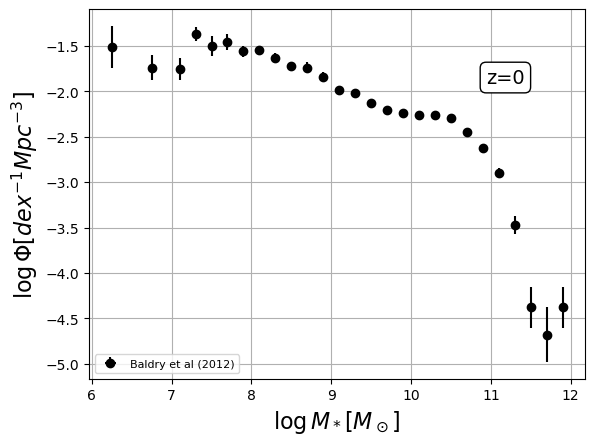

In [134]:
# Plot
name = 'baldry12'

save_data['gsmf'][name]['observables']['log_data']

plt.errorbar(save_data['gsmf'][name]['observables']['log_data']['x'], 
             save_data['gsmf'][name]['observables']['log_data']['y'], 
             xerr=save_data['gsmf'][name]['observables']['log_data']['xerr'], 
             yerr=save_data['gsmf'][name]['observables']['log_data']['yerr'], 
             fmt='o', label=save_data['gsmf'][name]['citation'], zorder=100, color='k')


#if smf.cond and z<0.2: plt.errorbar(smf.x, np.log10((10**smf.y)*bin_width), yerr=smf.yerr, fmt='o', label=smf.name, zorder=100, color='k')
# if baldry12_smf.cond and baldry12_z<0.2: plt.errorbar(baldry12_smf.x, baldry12_smf.y, yerr=baldry12_smf.yerr, fmt='o', label=baldry12_smf.name, zorder=100, color='k')

# plt.plot(baldry12_logM_ax, baldry12_Phi_schechter, ls='-',label='Schechter Fit')

plt.grid()
plt.legend(loc='lower left', prop={'size': 8},fontsize=10)
#plt.annotate('z=%g'%np.round(objs[j].simulation.redshift,0), xy=(0.8, 0.8), xycoords='axes fraction',size=14,bbox=dict(boxstyle="round", fc="w"))
plt.annotate('z=%g'%np.round(save_data['gsmf'][name]['z'],0), xy=(0.8, 0.8), xycoords='axes fraction',size=14,bbox=dict(boxstyle="round", fc="w"))
plt.ylabel(r'$\log \Phi [dex^{-1}Mpc^{-3}$]',fontsize=16)
#if irow == nrowmax-1: ax0.set_xlabel(r'$\log M_* [M_\odot]$',fontsize=16)
plt.xlabel(r'$\log M_* [M_\odot]$',fontsize=16)
plt.show()

## Muzzin+13 GSMF

3.5
/home/b/babul/aspadawe/scripts/rennehan/Observation_Romeel/Muzzin13/mf_z0.2_0.5.dat


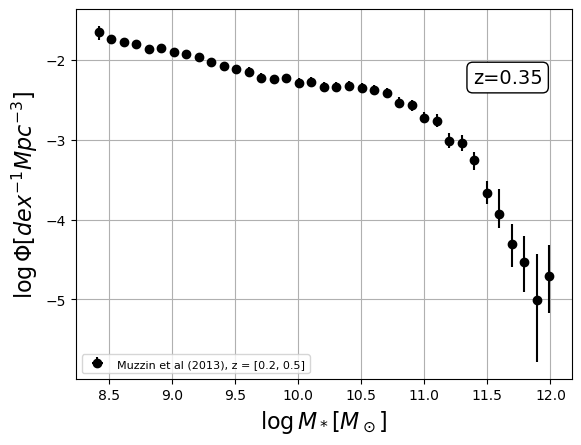

0.35
/home/b/babul/aspadawe/scripts/rennehan/Observation_Romeel/Muzzin13/mf_z0.5_1.0.dat


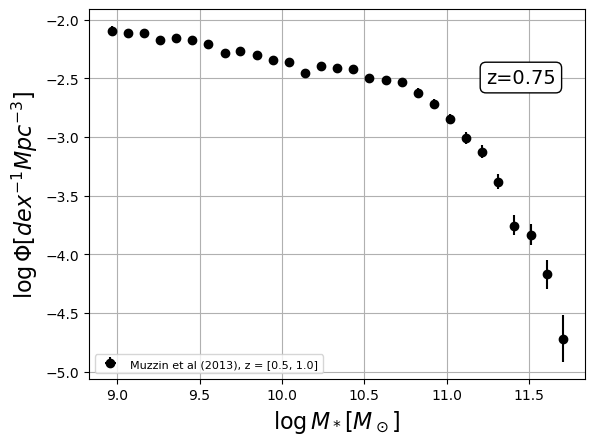

0.75
/home/b/babul/aspadawe/scripts/rennehan/Observation_Romeel/Muzzin13/mf_z1.0_1.5.dat


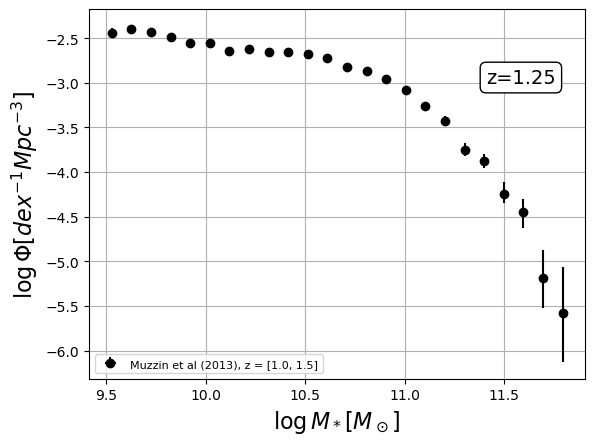

1.25
/home/b/babul/aspadawe/scripts/rennehan/Observation_Romeel/Muzzin13/mf_z1.5_2.0.dat


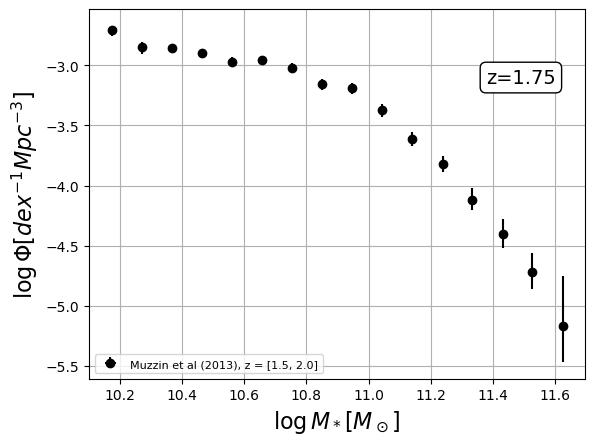

1.75
/home/b/babul/aspadawe/scripts/rennehan/Observation_Romeel/Muzzin13/mf_z2.0_2.5.dat


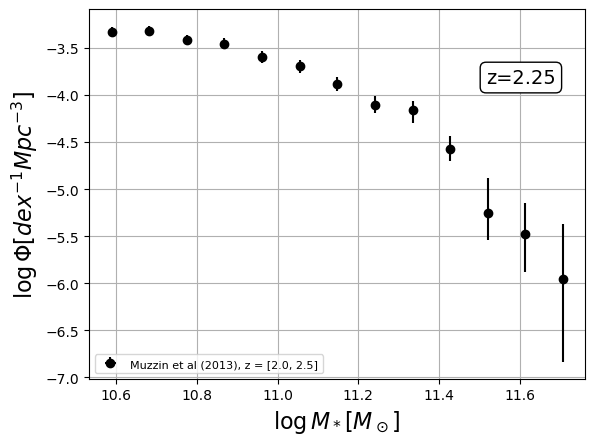

2.25
/home/b/babul/aspadawe/scripts/rennehan/Observation_Romeel/Muzzin13/mf_z2.5_3.0.dat


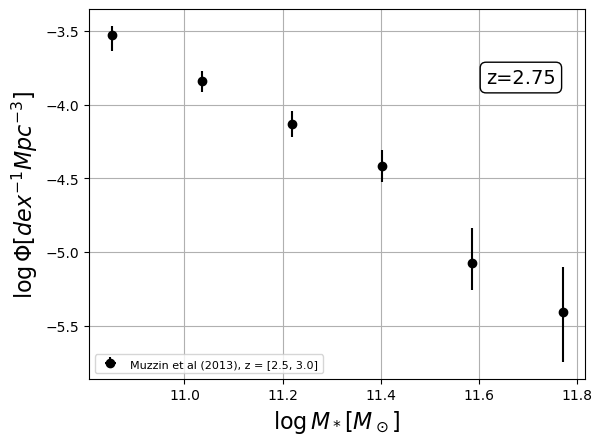

2.75
/home/b/babul/aspadawe/scripts/rennehan/Observation_Romeel/Muzzin13/mf_z3.0_4.0.dat


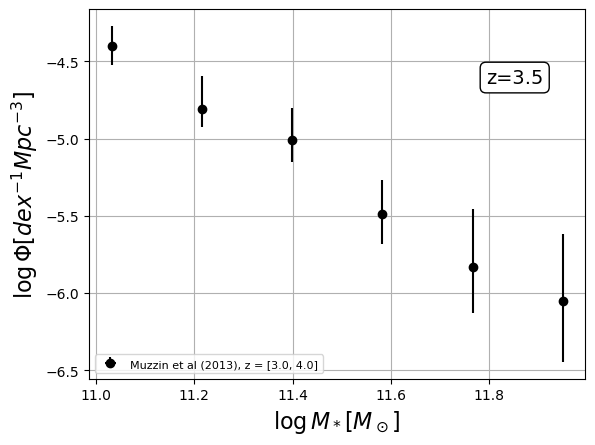

In [50]:
z_muzzin13 = [[0.2, 0.5], [0.5,1.0], [1.0,1.5], [1.5,2.0], [2.0,2.5], [2.5,3.0], [3.0,4.0]]
dir_muzzin13 = '/home/b/babul/aspadawe/scripts/rennehan/Observation_Romeel/Muzzin13'

for z_bounds_ in z_muzzin13:
    print(z_)
    z_ = (z_bounds_[0]+z_bounds_[1])/2.

    save_data['gsmf']['muzzin13_z'+str(z_)] = {
        'observables':{},
        'output_directory':'/home/b/babul/aspadawe/data/observations/gsmf',
        'output_folder':'Muzzin+13',
        'z':z_,
        'z_lo':z_bounds_[0],
        'z_hi':z_bounds_[1],
        'citation':'Muzzin et al (2013), z = %s' % z_bounds_,
        'bibcode':'',
        'cosmology':FlatLambdaCDM(name=r'Flat $\Lambda$CDM', H0=68 * u.km / u.s / u.Mpc, Om0=0.3),
    }
    
    file_ = os.path.join(dir_muzzin13, 'mf_z'+str(z_bounds_[0])+'_'+str(z_bounds_[1])+'.dat')
    print(file_)
    logx, logx_err, logy, logy_err_hi, logy_err_lo = np.genfromtxt(file_, usecols=(0,1,2,3,4), unpack=True)
    
    
#     smf = SMF(save_data['gsmf']['muzzin13_z'+str(z_)]['z'], name='TomSMF')
#     print(smf.name)
#     print(smf.z)

    save_data['gsmf']['muzzin13_z'+str(z_)]['observables']['log_data'] = {
        'x':logx * unyt.Solar_Mass,
        'xerr':np.zeros(len(logx)) * unyt.Solar_Mass,
        'y':logy * unyt.Mpc**(-3),
        'yerr':[logy_err_lo, logy_err_hi] * unyt.Mpc**(-3),
        'x_label':'log(Mstar)',
        'y_label':'log(Phi)',
        'plot_as':'points',
        'name':'GSMF fromm Muzzin+13',
        'comment':f'Assuming Chabrier (2003) IMF?. h-corrected for SWIFT using cosmology: %s.' % save_data['gsmf']['muzzin13_z'+str(z_)]['cosmology'].name,
    }
    
    
    
    
    # Plot
    name = 'muzzin13_z'+str(z_)

    save_data['gsmf'][name]['observables']['log_data']

    plt.errorbar(save_data['gsmf'][name]['observables']['log_data']['x'], 
                 save_data['gsmf'][name]['observables']['log_data']['y'], 
                 xerr=save_data['gsmf'][name]['observables']['log_data']['xerr'], 
                 yerr=save_data['gsmf'][name]['observables']['log_data']['yerr'], 
                 fmt='o', label=save_data['gsmf'][name]['citation'], zorder=100, color='k')


    #if smf.cond and z<0.2: plt.errorbar(smf.x, np.log10((10**smf.y)*bin_width), yerr=smf.yerr, fmt='o', label=smf.name, zorder=100, color='k')
    # if baldry12_smf.cond and baldry12_z<0.2: plt.errorbar(baldry12_smf.x, baldry12_smf.y, yerr=baldry12_smf.yerr, fmt='o', label=baldry12_smf.name, zorder=100, color='k')

    # plt.plot(baldry12_logM_ax, baldry12_Phi_schechter, ls='-',label='Schechter Fit')

    plt.grid()
    plt.legend(loc='lower left', prop={'size': 8}, fontsize=10)
    #plt.annotate('z=%g'%np.round(objs[j].simulation.redshift,0), xy=(0.8, 0.8), xycoords='axes fraction',size=14,bbox=dict(boxstyle="round", fc="w"))
    # plt.annotate('z=%g'%np.round(save_data['gsmf'][name]['z'],0), xy=(0.8, 0.8), xycoords='axes fraction',size=14,bbox=dict(boxstyle="round", fc="w"))
    plt.annotate('z=%g'%np.round(save_data['gsmf'][name]['z'],2), xy=(0.8, 0.8), xycoords='axes fraction',size=14,bbox=dict(boxstyle="round", fc="w"))
    plt.ylabel(r'$\log \Phi [dex^{-1}Mpc^{-3}$]',fontsize=16)
    #if irow == nrowmax-1: ax0.set_xlabel(r'$\log M_* [M_\odot]$',fontsize=16)
    plt.xlabel(r'$\log M_* [M_\odot]$',fontsize=16)
    plt.show()

## Tomczak+14 GSMF

OBSSMF: 0.2 0.2
Tomczak+14
0.2


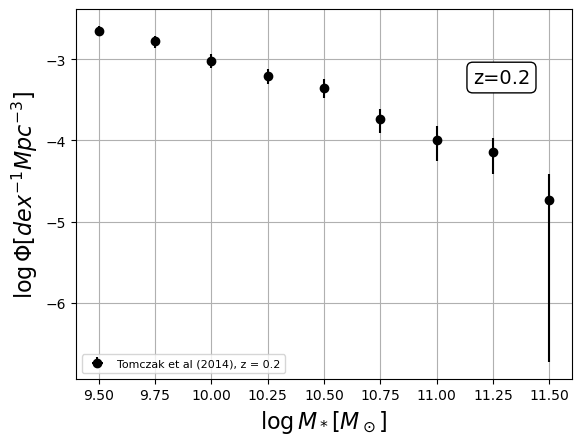

OBSSMF: 0.5 0.2
Tomczak+14
0.5


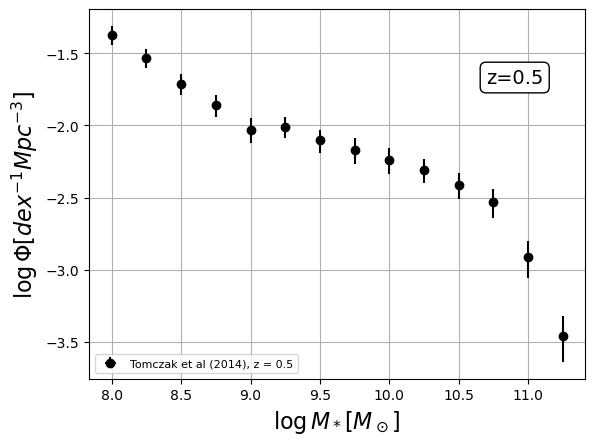

OBSSMF: 0.75 0.2
Tomczak+14
0.75


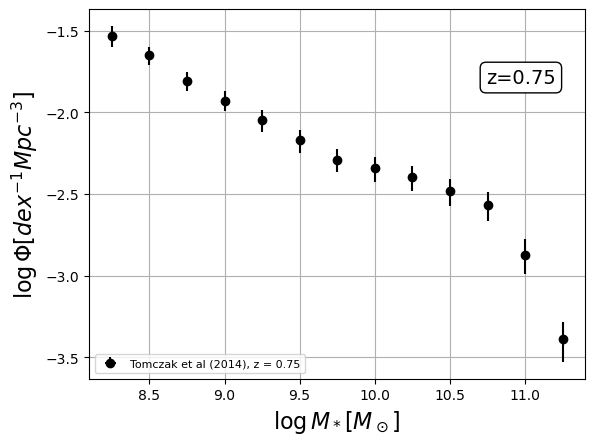

OBSSMF: 1.0 0.2
Tomczak+14
1.0


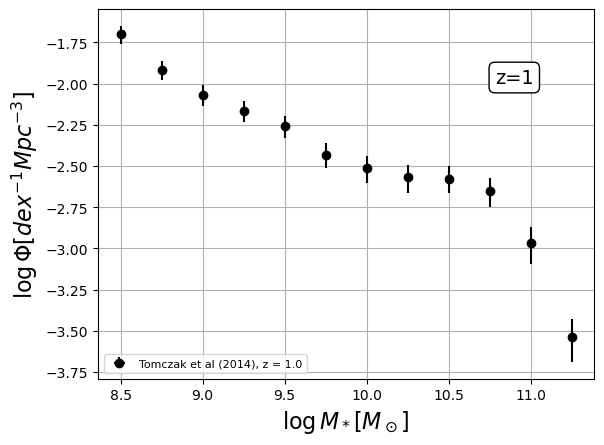

OBSSMF: 1.25 0.2
Tomczak+14
1.25


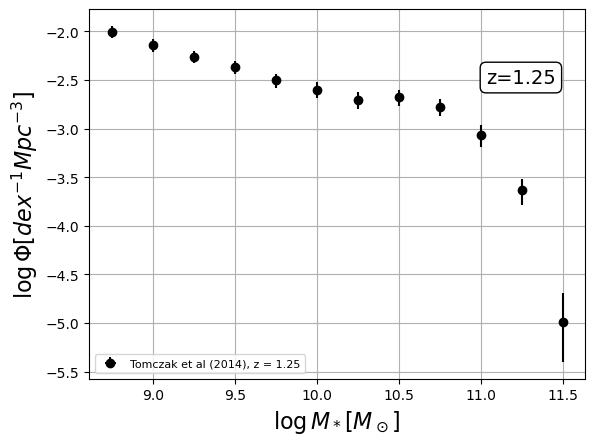

OBSSMF: 1.5 0.2
Tomczak+14
1.5


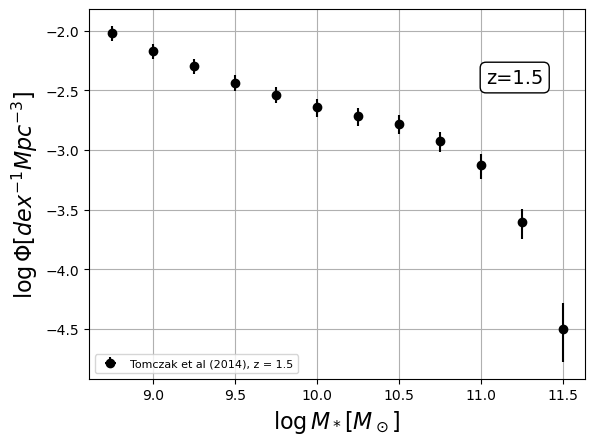

OBSSMF: 2.0 0.2
Tomczak+14
2.0


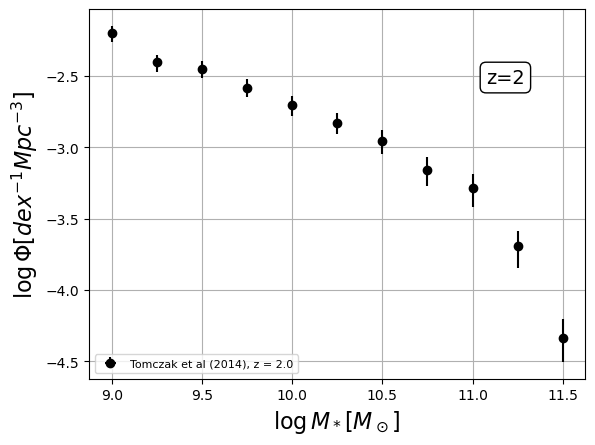

OBSSMF: 2.5 0.2
Tomczak+14
2.5


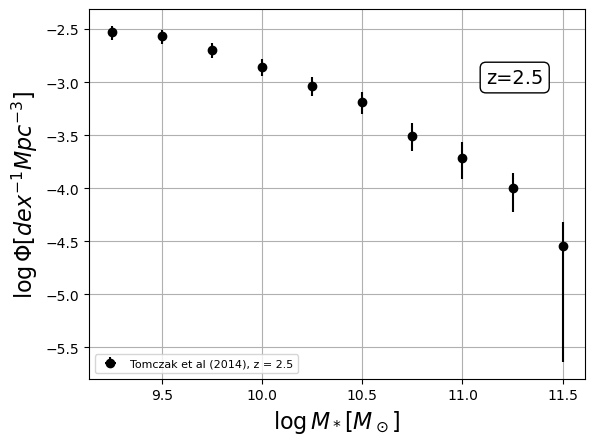

OBSSMF: 3.0 0.2
Tomczak+14
3.0


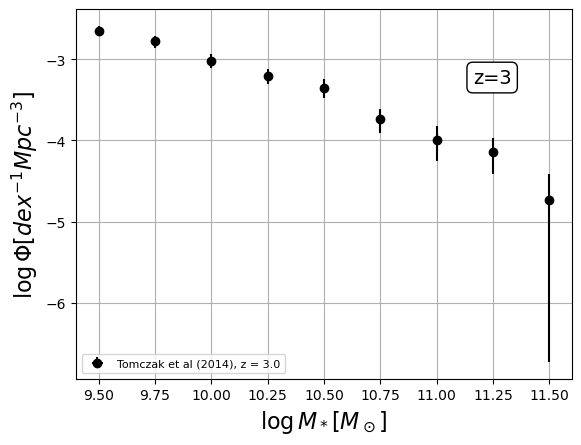

In [51]:
z_tomczak14 = np.array([0.2, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 2.5, 3.0])

for z_ in z_tomczak14:

    save_data['gsmf']['tomczak14_z'+str(z_)] = {
        'observables':{},
        'output_directory':'/home/b/babul/aspadawe/data/observations/gsmf',
        'output_folder':'Tomczak+14',
        'z':z_,
        'z_lo':z_-0.1,
        'z_hi':z_+0.1,
        'citation':'Tomczak et al (2014), z = %s' % z_,
        'bibcode':'',
        'cosmology':FlatLambdaCDM(name=r'Flat $\Lambda$CDM', H0=68 * u.km / u.s / u.Mpc, Om0=0.3),
    }
    
    smf = SMF(save_data['gsmf']['tomczak14_z'+str(z_)]['z'], name='TomSMF')
    print(smf.name)
    print(smf.z)

    save_data['gsmf']['tomczak14_z'+str(z_)]['observables']['log_data'] = {
        'x':smf.x * unyt.Solar_Mass,
        'xerr':np.zeros(len(smf.x)) * unyt.Solar_Mass,
        'y':smf.y * unyt.Mpc**(-3),
        'yerr':smf.yerr * unyt.Mpc**(-3),
        'x_label':'log(Mstar)',
        'y_label':'log(Phi)',
        'plot_as':'points',
        'name':'GSMF fromm Tomczak14',
        'comment':f'Assuming Chabrier (2003) IMF?. h-corrected for SWIFT using cosmology: %s.' % save_data['gsmf']['tomczak14_z'+str(z_)]['cosmology'].name,
    }
    
    
    
    
    # Plot
    name = 'tomczak14_z'+str(z_)

    save_data['gsmf'][name]['observables']['log_data']

    plt.errorbar(save_data['gsmf'][name]['observables']['log_data']['x'], 
                 save_data['gsmf'][name]['observables']['log_data']['y'], 
                 xerr=save_data['gsmf'][name]['observables']['log_data']['xerr'], 
                 yerr=save_data['gsmf'][name]['observables']['log_data']['yerr'], 
                 fmt='o', label=save_data['gsmf'][name]['citation'], zorder=100, color='k')


    #if smf.cond and z<0.2: plt.errorbar(smf.x, np.log10((10**smf.y)*bin_width), yerr=smf.yerr, fmt='o', label=smf.name, zorder=100, color='k')
    # if baldry12_smf.cond and baldry12_z<0.2: plt.errorbar(baldry12_smf.x, baldry12_smf.y, yerr=baldry12_smf.yerr, fmt='o', label=baldry12_smf.name, zorder=100, color='k')

    # plt.plot(baldry12_logM_ax, baldry12_Phi_schechter, ls='-',label='Schechter Fit')

    plt.grid()
    plt.legend(loc='lower left', prop={'size': 8}, fontsize=10)
    #plt.annotate('z=%g'%np.round(objs[j].simulation.redshift,0), xy=(0.8, 0.8), xycoords='axes fraction',size=14,bbox=dict(boxstyle="round", fc="w"))
    # plt.annotate('z=%g'%np.round(save_data['gsmf'][name]['z'],0), xy=(0.8, 0.8), xycoords='axes fraction',size=14,bbox=dict(boxstyle="round", fc="w"))
    plt.annotate('z=%g'%np.round(save_data['gsmf'][name]['z'],2), xy=(0.8, 0.8), xycoords='axes fraction',size=14,bbox=dict(boxstyle="round", fc="w"))
    plt.ylabel(r'$\log \Phi [dex^{-1}Mpc^{-3}$]',fontsize=16)
    #if irow == nrowmax-1: ax0.set_xlabel(r'$\log M_* [M_\odot]$',fontsize=16)
    plt.xlabel(r'$\log M_* [M_\odot]$',fontsize=16)
    plt.show()

## Song+15 GSMF

OBSSMF: 4.0 0.2
Song+15
4.0


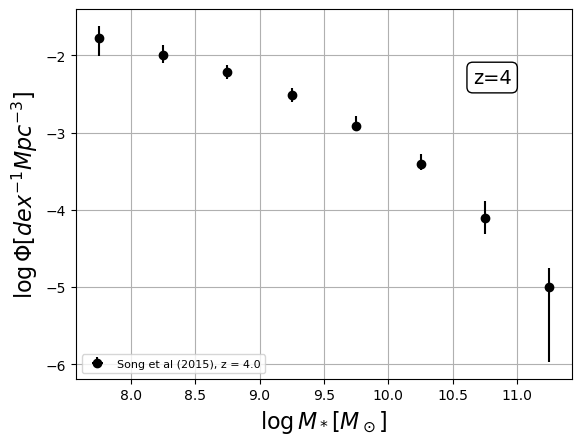

OBSSMF: 5.0 0.2
Song+15
5.0


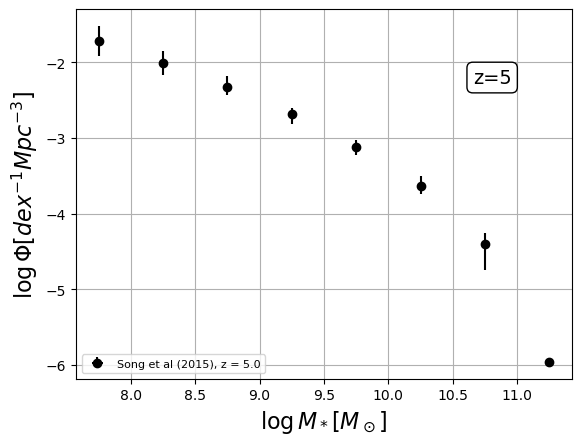

OBSSMF: 6.0 0.2
Song+15
6.0


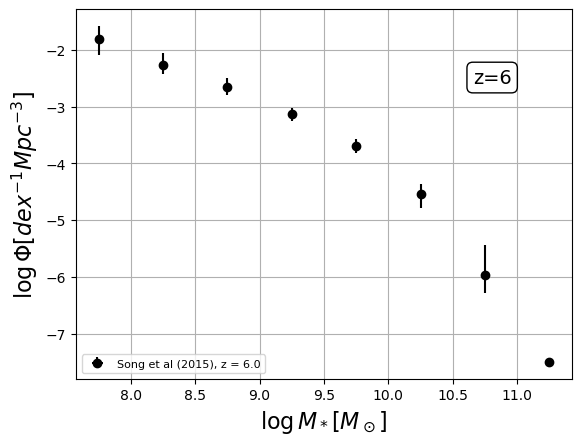

In [52]:
z_song15 = np.array([4.0, 5.0, 6.0])

for z_ in z_song15:

    save_data['gsmf']['song15_z'+str(z_)] = {
        'observables':{},
        'output_directory':'/home/b/babul/aspadawe/data/observations/gsmf',
        'output_folder':'Song+15',
        'z':z_,
        'z_lo':z_-0.1,
        'z_hi':z_+0.1,
        'citation':'Song et al (2015), z = %s' % z_,
        'bibcode':'',
        'cosmology':FlatLambdaCDM(name=r'Flat $\Lambda$CDM', H0=68 * u.km / u.s / u.Mpc, Om0=0.3),
    }
    
    smf = SMF(save_data['gsmf']['song15_z'+str(z_)]['z'], name='SongSMF')
    print(smf.name)
    print(smf.z)

    save_data['gsmf']['song15_z'+str(z_)]['observables']['log_data'] = {
        'x':smf.x * unyt.Solar_Mass,
        'xerr':np.zeros(len(smf.x)) * unyt.Solar_Mass,
        'y':smf.y * unyt.Mpc**(-3),
        'yerr':smf.yerr * unyt.Mpc**(-3),
        'x_label':'log(Mstar)',
        'y_label':'log(Phi)',
        'plot_as':'points',
        'name':'GSMF fromm Song+15',
        'comment':f'Assuming Chabrier (2003) IMF?. h-corrected for SWIFT using cosmology: %s.' % save_data['gsmf']['song15_z'+str(z_)]['cosmology'].name,
    }
    
    
    
    
    # Plot
    name = 'song15_z'+str(z_)

    save_data['gsmf'][name]['observables']['log_data']

    plt.errorbar(save_data['gsmf'][name]['observables']['log_data']['x'], 
                 save_data['gsmf'][name]['observables']['log_data']['y'], 
                 xerr=save_data['gsmf'][name]['observables']['log_data']['xerr'], 
                 yerr=save_data['gsmf'][name]['observables']['log_data']['yerr'], 
                 fmt='o', label=save_data['gsmf'][name]['citation'], zorder=100, color='k')


    #if smf.cond and z<0.2: plt.errorbar(smf.x, np.log10((10**smf.y)*bin_width), yerr=smf.yerr, fmt='o', label=smf.name, zorder=100, color='k')
    # if baldry12_smf.cond and baldry12_z<0.2: plt.errorbar(baldry12_smf.x, baldry12_smf.y, yerr=baldry12_smf.yerr, fmt='o', label=baldry12_smf.name, zorder=100, color='k')

    # plt.plot(baldry12_logM_ax, baldry12_Phi_schechter, ls='-',label='Schechter Fit')

    plt.grid()
    plt.legend(loc='lower left', prop={'size': 8}, fontsize=10)
    #plt.annotate('z=%g'%np.round(objs[j].simulation.redshift,0), xy=(0.8, 0.8), xycoords='axes fraction',size=14,bbox=dict(boxstyle="round", fc="w"))
    # plt.annotate('z=%g'%np.round(save_data['gsmf'][name]['z'],0), xy=(0.8, 0.8), xycoords='axes fraction',size=14,bbox=dict(boxstyle="round", fc="w"))
    plt.annotate('z=%g'%np.round(save_data['gsmf'][name]['z'],2), xy=(0.8, 0.8), xycoords='axes fraction',size=14,bbox=dict(boxstyle="round", fc="w"))
    plt.ylabel(r'$\log \Phi [dex^{-1}Mpc^{-3}$]',fontsize=16)
    #if irow == nrowmax-1: ax0.set_xlabel(r'$\log M_* [M_\odot]$',fontsize=16)
    plt.xlabel(r'$\log M_* [M_\odot]$',fontsize=16)
    plt.show()

## Wright+17 GSMF

OBSSMF: 0 0.2
Wright+17
0


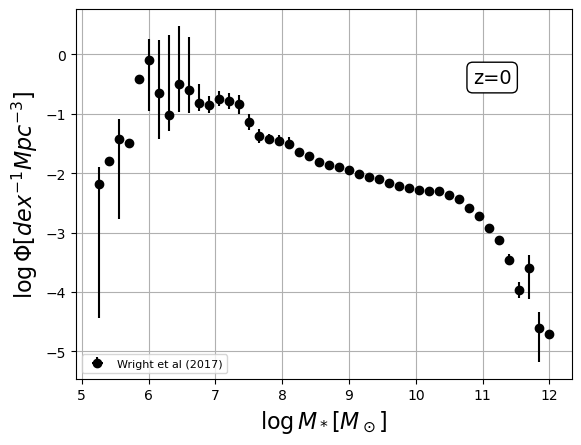

In [36]:
z_wright17 = np.array([0])

for z_ in z_wright17:

    save_data['gsmf']['wright17_z'+str(z_)] = {
        'observables':{},
        'output_directory':'/home/b/babul/aspadawe/data/observations/gsmf',
        'output_folder':'Wright+17',
        'z':z_,
        'z_lo':0,
        'z_hi':0,
        'citation':'Wright et al (2017)',
        'bibcode':'',
        'cosmology':FlatLambdaCDM(name=r'Flat $\Lambda$CDM', H0=68 * u.km / u.s / u.Mpc, Om0=0.3),
    }
    
    smf = SMF(save_data['gsmf']['wright17_z'+str(z_)]['z'], name='WrightSMF')
    print(smf.name)
    print(smf.z)

    save_data['gsmf']['wright17_z'+str(z_)]['observables']['log_data'] = {
        'x':smf.x * unyt.Solar_Mass,
        'xerr':np.zeros(len(smf.x)) * unyt.Solar_Mass,
        'y':smf.y * unyt.Mpc**(-3),
        'yerr':smf.yerr * unyt.Mpc**(-3),
        'x_label':'log(Mstar)',
        'y_label':'log(Phi)',
        'plot_as':'points',
        'name':'GSMF fromm Wright+17',
        'comment':f'Assuming Chabrier (2003) IMF?. h-corrected for SWIFT using cosmology: %s.' % save_data['gsmf']['wright17_z'+str(z_)]['cosmology'].name,
    }
    
    
    
    
    # Plot
    name = 'wright17_z'+str(z_)

    save_data['gsmf'][name]['observables']['log_data']

    plt.errorbar(save_data['gsmf'][name]['observables']['log_data']['x'], 
                 save_data['gsmf'][name]['observables']['log_data']['y'], 
                 xerr=save_data['gsmf'][name]['observables']['log_data']['xerr'], 
                 yerr=save_data['gsmf'][name]['observables']['log_data']['yerr'], 
                 fmt='o', label=save_data['gsmf'][name]['citation'], zorder=100, color='k')


    #if smf.cond and z<0.2: plt.errorbar(smf.x, np.log10((10**smf.y)*bin_width), yerr=smf.yerr, fmt='o', label=smf.name, zorder=100, color='k')
    # if baldry12_smf.cond and baldry12_z<0.2: plt.errorbar(baldry12_smf.x, baldry12_smf.y, yerr=baldry12_smf.yerr, fmt='o', label=baldry12_smf.name, zorder=100, color='k')

    # plt.plot(baldry12_logM_ax, baldry12_Phi_schechter, ls='-',label='Schechter Fit')

    plt.grid()
    plt.legend(loc='lower left', prop={'size': 8}, fontsize=10)
    #plt.annotate('z=%g'%np.round(objs[j].simulation.redshift,0), xy=(0.8, 0.8), xycoords='axes fraction',size=14,bbox=dict(boxstyle="round", fc="w"))
    # plt.annotate('z=%g'%np.round(save_data['gsmf'][name]['z'],0), xy=(0.8, 0.8), xycoords='axes fraction',size=14,bbox=dict(boxstyle="round", fc="w"))
    plt.annotate('z=%g'%np.round(save_data['gsmf'][name]['z'],2), xy=(0.8, 0.8), xycoords='axes fraction',size=14,bbox=dict(boxstyle="round", fc="w"))
    plt.ylabel(r'$\log \Phi [dex^{-1}Mpc^{-3}$]',fontsize=16)
    #if irow == nrowmax-1: ax0.set_xlabel(r'$\log M_* [M_\odot]$',fontsize=16)
    plt.xlabel(r'$\log M_* [M_\odot]$',fontsize=16)
    plt.show()

## Bernardi+17 GSMF

In [224]:
save_data['gsmf']['bernardi17'] = {
    'observables':{},
    'output_directory':'/home/b/babul/aspadawe/data/observations/gsmf',
    'output_folder':'Bernardi+17',
    'z':0,
    'z_lo':0,
    'z_hi':0,
    'citation':'Bernardi et al (2017)',
    'bibcode':'2017MNRAS.467.2217B',
    'cosmology':FlatLambdaCDM(name=r'Flat $\Lambda$CDM', H0=68 * u.km / u.s / u.Mpc, Om0=0.3),
}

In [227]:
smf = SMF(save_data['gsmf']['bernardi17']['z'], name='BernSMF')

save_data['gsmf']['bernardi17']['observables']['log_data'] = {
    'x':smf.x * unyt.Solar_Mass,
    'xerr':np.zeros(len(smf.x)) * unyt.Solar_Mass,
    'y':smf.y * unyt.Mpc**(-3),
    'yerr':smf.yerr * unyt.Mpc**(-3),
    'x_label':'log(Mstar)',
    'y_label':'log(Phi)',
    'plot_as':'points',
    'name':'GSMF from SDSS',
    'comment':f'Assuming Chabrier (2003) IMF. h-corrected for SWIFT using cosmology: %s.' % save_data['gsmf']['bernardi17']['cosmology'].name,
}

save_data['gsmf']['bernardi17']['observables']['log_data_v2'] = {
    'x':smf.x * unyt.Solar_Mass,
    'xerr':np.zeros(len(smf.x)) * unyt.Solar_Mass,
    'y':smf.y * unyt.Mpc**(-3),
    'yerr':np.abs(0.05*smf.y) * unyt.Mpc**(-3),
    'x_label':'log(Mstar)',
    'y_label':'log(Phi)',
    'plot_as':'points',
    'name':'GSMF from SDSS',
    'comment':f'Assuming Chabrier (2003) IMF. h-corrected for SWIFT using cosmology: %s.' % save_data['gsmf']['bernardi17']['cosmology'].name,
}

OBSSMF: 0 0.2


In [37]:
# Not correct for Bernardi+17
def bern_gsmf_schec(logM):
    # Baldry+12 eqn 6
    # values/parameters changed so 
    log_Mstar = 10.66  # +/- 0.05
    phi1 = 3.96e-3  # +/- 0.34e-3
    phi2 = 0.79e-3  # +/- 0.23e-3
    alpha1 = -0.35  # +/- 0.18
    alpha2 = -1.47  # +/- 0.05
            
    Delta_logM_logMstar = logM - log_Mstar
    
    PhiM = np.log(10) * np.exp(-10**Delta_logM_logMstar) * 10**Delta_logM_logMstar * (
        phi1 * 10**(Delta_logM_logMstar * alpha1) + phi2 * 10**(Delta_logM_logMstar * alpha2))

    return np.log10(PhiM)

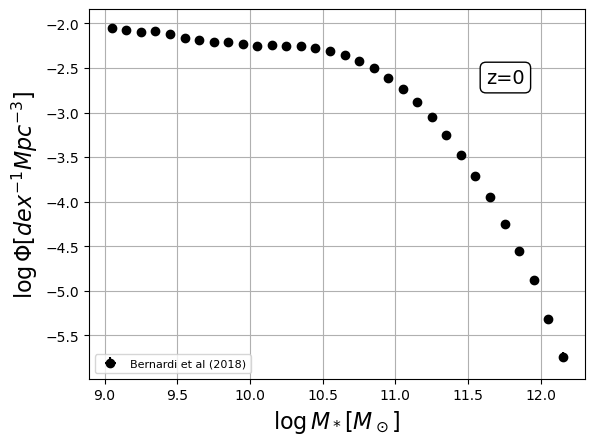

In [136]:
# Plot
name = 'bernardi18'

save_data['gsmf'][name]['observables']['log_data']

plt.errorbar(save_data['gsmf'][name]['observables']['log_data']['x'], 
             save_data['gsmf'][name]['observables']['log_data']['y'], 
             xerr=save_data['gsmf'][name]['observables']['log_data']['xerr'], 
             yerr=save_data['gsmf'][name]['observables']['log_data']['yerr'], 
             fmt='o', label=save_data['gsmf'][name]['citation'], zorder=100, color='k')


#if smf.cond and z<0.2: plt.errorbar(smf.x, np.log10((10**smf.y)*bin_width), yerr=smf.yerr, fmt='o', label=smf.name, zorder=100, color='k')
# if baldry12_smf.cond and baldry12_z<0.2: plt.errorbar(baldry12_smf.x, baldry12_smf.y, yerr=baldry12_smf.yerr, fmt='o', label=baldry12_smf.name, zorder=100, color='k')

# plt.plot(baldry12_logM_ax, baldry12_Phi_schechter, ls='-',label='Schechter Fit')

plt.grid()
plt.legend(loc='lower left', prop={'size': 8},fontsize=10)
#plt.annotate('z=%g'%np.round(objs[j].simulation.redshift,0), xy=(0.8, 0.8), xycoords='axes fraction',size=14,bbox=dict(boxstyle="round", fc="w"))
plt.annotate('z=%g'%np.round(save_data['gsmf'][name]['z'],0), xy=(0.8, 0.8), xycoords='axes fraction',size=14,bbox=dict(boxstyle="round", fc="w"))
plt.ylabel(r'$\log \Phi [dex^{-1}Mpc^{-3}$]',fontsize=16)
#if irow == nrowmax-1: ax0.set_xlabel(r'$\log M_* [M_\odot]$',fontsize=16)
plt.xlabel(r'$\log M_* [M_\odot]$',fontsize=16)
plt.show()

## Driver+22 GSMF

In [16]:
save_data['gsmf']['driver22'] = {
    'observables':{},
    'output_directory':'/home/b/babul/aspadawe/data/observations/gsmf',
    'output_folder':'Driver+22',
    'z':0,
    'z_lo':0,
    'z_hi':0.1,
    'citation':'Driver et al (2022)',
    'bibcode':'2022MNRAS.513..439D',
    'cosmology':FlatLambdaCDM(name=r'Flat $\Lambda$CDM', H0=68 * u.km / u.s / u.Mpc, Om0=0.3),
}

In [17]:
redshift_zero_correction_driver22 = 0.0807  # dex
data_file = '/home/b/babul/aspadawe/data/observations/gsmf/Driver22/Driver+22_gsmf.txt'
df = pd.read_csv(data_file, sep='\s+', index_col=False, skiprows=4, dtype=float)
# df

log_Mstar_corr_driver22 = df['log10(Mstar/Msun*h70^-2)'].to_numpy() + 2*np.log10(save_data['gsmf']['driver22']['cosmology'].h * 100. / 70.)
log_Phi_corr_driver22 = df['log10(Phi/dex/Mpc^3*h70^-3)'].to_numpy() + redshift_zero_correction_driver22 + 3*np.log10(save_data['gsmf']['driver22']['cosmology'].h * 100. / 70.)
log_err_Phi_corr_driver22 = df['sigma_log10(Phi/dex/Mpc^3*h70^-3)'].to_numpy() + redshift_zero_correction_driver22 + 3*np.log10(save_data['gsmf']['driver22']['cosmology'].h * 100. / 70.)

isfinite = np.isfinite(log_Phi_corr_driver22)
log_Mstar_corr_driver22 = log_Mstar_corr_driver22[isfinite]
log_Phi_corr_driver22 = log_Phi_corr_driver22[isfinite]
log_err_Phi_corr_driver22 = log_err_Phi_corr_driver22[isfinite]


save_data['gsmf']['driver22']['observables']['log_data'] = {
    'x':log_Mstar_corr_driver22 * unyt.Solar_Mass,
    'xerr':np.zeros(len(log_Mstar_corr_driver22)) * unyt.Solar_Mass,
    'y':log_Phi_corr_driver22 * unyt.Mpc**(-3),
    'yerr':log_err_Phi_corr_driver22 * unyt.Mpc**(-3),
    'x_label':'log(Mstar)',
    'y_label':'log(Phi)',
    'plot_as':'points',
    'name':'GSMF from GAMA',
    'comment':f'Assuming Chabrier (2003) IMF. h-corrected for SWIFT using cosmology: %s, and corrected to SDSS and redshift zero.' % save_data['gsmf']['driver22']['cosmology'].name,
}

In [26]:
def driver_gsmf_schec(logM, redshift_zero_correction):
    log_Mstar = 10.745  # +/- 0.020 [Msun h70^-2]
    log_phi1 = -2.437 + redshift_zero_correction  # +/- 0.016 [Mpc^-3 h70^3]
    log_phi2 = -3.201 + redshift_zero_correction  # +/- 0.064 [Mpc^-3 h70^3]
    alpha1 = -0.466  # +/- 0.069
    alpha2 = -1.530  # +/- 0.027
    log_rhostar = 8.392  # +/- 0.006 [Msun Mpc^-3 h70]
            
    Delta_logM_logMstar = logM - log_Mstar
    
#     PhiM = np.exp(-10**(Delta_logM_logMstar)) * (
#         10**(log_phi1 + alpha1*Delta_logM_logMstar) + 10**(log_phi2 + alpha2*Delta_logM_logMstar)) * 10**(-log_Mstar)
    PhiM = np.log(10) * np.exp(-10**Delta_logM_logMstar) * 10**Delta_logM_logMstar * (
        10**(log_phi1 + alpha1*Delta_logM_logMstar) + 10**(log_phi2 + alpha2*Delta_logM_logMstar))

    return np.log10(PhiM)

In [33]:
# GSMF (schechter fit)
dlogM = 0.5
bins = np.arange(6, 12+dlogM, dlogM)
logM_ax = bins[0:-1] + dlogM/2.

driver_schec = driver_gsmf_schec(logM_ax, redshift_zero_correction_driver22)

driver22_save_data['log_schechter_fit'] = {'x':logM_ax * unyt.Solar_Mass,
                            'xerr':np.zeros(len(logM_ax)) * unyt.Solar_Mass,
                            'y':driver_schec * unyt.Mpc**(-3),
                            'yerr':np.zeros(len(driver_schec)) * unyt.Mpc**(-3)}

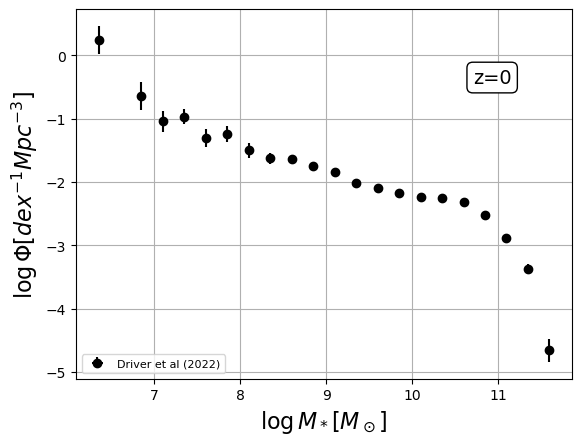

In [135]:
# Plot
name = 'driver22'

save_data['gsmf'][name]['observables']['log_data']

plt.errorbar(save_data['gsmf'][name]['observables']['log_data']['x'], 
             save_data['gsmf'][name]['observables']['log_data']['y'], 
             xerr=save_data['gsmf'][name]['observables']['log_data']['xerr'], 
             yerr=save_data['gsmf'][name]['observables']['log_data']['yerr'], 
             fmt='o', label=save_data['gsmf'][name]['citation'], zorder=100, color='k')


#if smf.cond and z<0.2: plt.errorbar(smf.x, np.log10((10**smf.y)*bin_width), yerr=smf.yerr, fmt='o', label=smf.name, zorder=100, color='k')
# if baldry12_smf.cond and baldry12_z<0.2: plt.errorbar(baldry12_smf.x, baldry12_smf.y, yerr=baldry12_smf.yerr, fmt='o', label=baldry12_smf.name, zorder=100, color='k')

# plt.plot(baldry12_logM_ax, baldry12_Phi_schechter, ls='-',label='Schechter Fit')

plt.grid()
plt.legend(loc='lower left', prop={'size': 8},fontsize=10)
#plt.annotate('z=%g'%np.round(objs[j].simulation.redshift,0), xy=(0.8, 0.8), xycoords='axes fraction',size=14,bbox=dict(boxstyle="round", fc="w"))
plt.annotate('z=%g'%np.round(save_data['gsmf'][name]['z'],0), xy=(0.8, 0.8), xycoords='axes fraction',size=14,bbox=dict(boxstyle="round", fc="w"))
plt.ylabel(r'$\log \Phi [dex^{-1}Mpc^{-3}$]',fontsize=16)
#if irow == nrowmax-1: ax0.set_xlabel(r'$\log M_* [M_\odot]$',fontsize=16)
plt.xlabel(r'$\log M_* [M_\odot]$',fontsize=16)
plt.show()

## GSWLC-X2 (GALEX-SDSS-WISE-Legacy Catalog): sSFR Histogram and Quenched Fraction

In [138]:
min_log_Mstar = 9
max_log_Mstar = 13

In [139]:
file = '/scratch/b/babul/renierht/Python_scripts/Observation_Romeel/GSWLC/GSWLC-X2.dat'
GSWLC_z, log_Mstar, sigma_log_Mstar, log_sfr, sigma_log_sfr, flag_sed, flag_mgs = np.genfromtxt(file, 
                                                                                                usecols=(7,9,10,11,12,19,23), 
                                                                                                unpack=True)

log_ssfr = log_sfr - log_Mstar + 9  # Gyr^-1
# sigma_log_ssfr = sigma_log_sfr - sigma_log_Mstar + 9  # Gyr^-1  (Need to add in quadrature??)
sigma_log_ssfr = np.sqrt(sigma_log_sfr**2 + sigma_log_Mstar**2) + 9  # Gyr^-1 ???

mgs_select = flag_mgs==1
sed_select = flag_sed==0
select = np.logical_and(mgs_select, sed_select)

GSWLC_z = GSWLC_z[select]
log_Mstar = log_Mstar[select]
sigma_log_Mstar = sigma_log_Mstar[select]
log_sfr = log_sfr[select]
sigma_log_sfr = sigma_log_sfr[select]
log_ssfr = log_ssfr[select]
sigma_log_ssfr = sigma_log_ssfr[select]

In [140]:
save_data['ssfr']['gswlc-x2'] = {
    'observables':{},
    'output_directory':'/home/b/babul/aspadawe/data/observations/ssfr',
    'output_folder':'gswlc-x2',
    'z':0.5*(max(GSWLC_z)+min(GSWLC_z)),
    'z_lo':min(GSWLC_z),
    'z_hi':max(GSWLC_z),
    'citation':'GSWLC-X2 (GALEX-SDSS-WISE-Legacy Catalog)',
    'bibcode':'',
    'cosmology':FlatLambdaCDM(name=r'Flat $\Lambda$CDM', H0=68 * u.km / u.s / u.Mpc, Om0=0.3),
}

In [146]:
logM_bins_ssfr_hist = np.array([9, 10, 11, 20])
# log_ssfr_bins = np.arange(-3, 1, 0.2)
log_ssfr_bins_ssfr_hist = np.arange(-3.1, 1, 0.2)
# print(log_ssfr_bins)
log_ssfr_lim = -2.5 + 0.3*0

log_ssfr_hists = gen.log_ssfr_hist_func(logM_bins_ssfr_hist, log_ssfr_bins, log_Mstar, log_ssfr, log_ssfr_lim=log_ssfr_lim)


for ii in range(len(log_ssfr_hists)):
    save_data['ssfr']['gswlc-x2']['observables']['ssfr_hist_bin_%s' % ii] = {
        'x':log_ssfr_hists[ii][0] * unyt.Gyr**(-1),
        'xerr':np.zeros(len(log_ssfr_hists[ii][0])) * unyt.Gyr**(-1),
        'y':log_ssfr_hists[ii][1] * unyt.dimensionless,
        'yerr':log_ssfr_hists[ii][2] * unyt.dimensionless,
        'x_label':'log(sSFR)',
        'y_label':'fraction',
        'plot_as':'line',
        'name':'sSFR histogram from GSWLC-X2',
        'comment':f'h-corrected for SWIFT using cosmology: %s.' % save_data['ssfr']['gswlc-x2']['cosmology'].name,
    }

In [145]:
logM_bins_quenched_frac = np.array([9, 10, 11, 20])
log_ssfr_bins_quenched_frac = np.array([-np.inf, -2.5])
# log_ssfr_bins_ = np.array([-np.inf, -2.5, np.inf])
# log_ssfr_bins_ = log_ssfr_bins
quenched_fraction = gen.ssfr_fraction_func(log_Mstar, log_ssfr, log_ssfr_bins_quenched_frac, dlogM=1,
                                           min_logM=9, max_logM=15, calc_min_logM=False, calc_max_logM=False)
quenched_fraction_v2 = gen.ssfr_fraction_func_v2(log_Mstar, log_ssfr, logM_bins_quenched_frac, log_ssfr_bins_quenched_frac)


for ii in range(len(quenched_fraction)):
    save_data['ssfr']['gswlc-x2']['observables']['quenched_fraction'] = {
        'x':quenched_fraction[ii][0] * unyt.Solar_Mass,
        'xerr':np.zeros(len(quenched_fraction[ii][0])) * unyt.Solar_Mass,
        'y':quenched_fraction[ii][1] * unyt.dimensionless,
        'yerr':quenched_fraction[ii][2] * unyt.dimensionless,
        'x_label':'log(Mstar)',
        'y_label':'quenched fraction',
        'plot_as':'line',
        'name':'Quenched fration from GSWLC-X2',
        'comment':f'h-corrected for SWIFT using cosmology: %s.' % save_data['ssfr']['gswlc-x2']['cosmology'].name,
    }
    
    save_data['ssfr']['gswlc-x2']['observables']['quenched_fraction_v2'] = {
        'x':quenched_fraction_v2[ii][0] * unyt.Solar_Mass,
        'xerr':np.zeros(len(quenched_fraction_v2[ii][0])) * unyt.Solar_Mass,
        'y':quenched_fraction_v2[ii][1] * unyt.dimensionless,
        'yerr':quenched_fraction_v2[ii][2] * unyt.dimensionless,
        'x_label':'log(Mstar)',
        'y_label':'quenched fraction',
        'plot_as':'line',
        'name':'Quenched fration from GSWLC-X2',
        'comment':f'h-corrected for SWIFT using cosmology: %s.' % save_data['ssfr']['gswlc-x2']['cosmology'].name,
    }

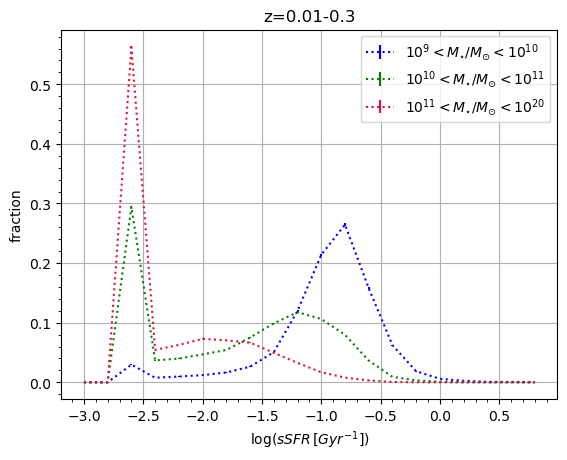

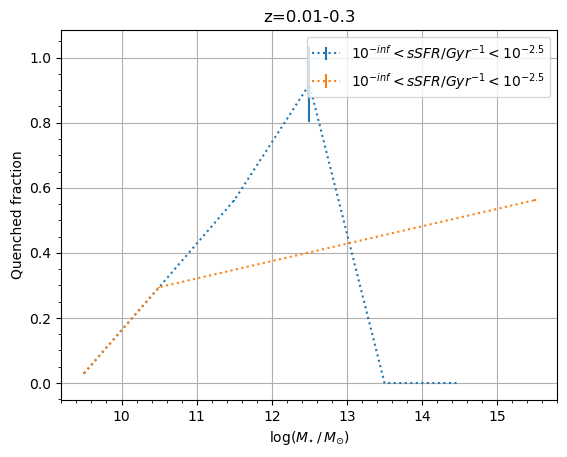

In [149]:
name = 'gswlc-x2'


# sSFR histograms
plt.clf()
plt.xlabel(r'$\log(sSFR\,[Gyr^{-1}])$')
plt.ylabel(r'fraction')
plt.title(r'z=%s-%s' % (save_data['ssfr']['gswlc-x2']['z_lo'], save_data['ssfr']['gswlc-x2']['z_hi']))
plt.grid()
plt.minorticks_on()

colors = ['b', 'g', 'crimson', 'm', 'r', 'y', 'k']
# colors = ["navy","darkgreen","darkred"]
# colors = ["aqua","limegreen","r"]
# labels = ["Simba","Simba-C"]
# linestyles = ["-.","-"]


for ii in range(len(log_ssfr_hists)):
    plt.errorbar(save_data['ssfr']['gswlc-x2']['observables']['ssfr_hist_bin_%s' % ii]['x'], 
                 save_data['ssfr']['gswlc-x2']['observables']['ssfr_hist_bin_%s' % ii]['y'], 
                 yerr=save_data['ssfr']['gswlc-x2']['observables']['ssfr_hist_bin_%s' % ii]['yerr'], 
                 ls=':', color=colors[ii],
                 label=r'$10^{%s} < M_{\star}/M_{\odot} < 10^{%s}$' % (logM_bins_ssfr_hist[ii], logM_bins_ssfr_hist[ii+1]))


plt.legend()
plt.show()





# Quenched fractions

plt.clf()
plt.xlabel(r'$\log(M_{\star}\,/\,M_{\odot})$')
plt.ylabel(r'Quenched fraction')
plt.title(r'z=%s-%s' % (save_data['ssfr']['gswlc-x2']['z_lo'], save_data['ssfr']['gswlc-x2']['z_hi']))
plt.grid()
plt.minorticks_on()

colors = ['b', 'g', 'crimson', 'm', 'r', 'y', 'k']
# colors = ["navy","darkgreen","darkred"]
# colors = ["aqua","limegreen","r"]
# labels = ["Simba","Simba-C"]
# linestyles = ["-.","-"]


for ii in range(len(quenched_fraction)):
    plt.errorbar(save_data['ssfr']['gswlc-x2']['observables']['quenched_fraction']['x'], 
                 save_data['ssfr']['gswlc-x2']['observables']['quenched_fraction']['y'], 
                 yerr=save_data['ssfr']['gswlc-x2']['observables']['quenched_fraction']['yerr'], 
                 ls=':', 
                 label=r'$10^{%s} < sSFR/Gyr^{-1} < 10^{%s}$' % (log_ssfr_bins_quenched_frac[ii], log_ssfr_bins_quenched_frac[ii+1]))
    
    plt.errorbar(save_data['ssfr']['gswlc-x2']['observables']['quenched_fraction_v2']['x'], 
                 save_data['ssfr']['gswlc-x2']['observables']['quenched_fraction_v2']['y'], 
                 yerr=save_data['ssfr']['gswlc-x2']['observables']['quenched_fraction_v2']['yerr'], 
                 ls=':', 
                 label=r'$10^{%s} < sSFR/Gyr^{-1} < 10^{%s}$' % (log_ssfr_bins_quenched_frac[ii], log_ssfr_bins_quenched_frac[ii+1]))



plt.legend()
plt.show()

## Kormendy & Ho 2013 Black Hole mass - Stellar mass relation

In [150]:
# Table 2 (pg. 34)
# Fig. 18 (pg. 58)
# Fig. 21 (pg. 64)

In [151]:
#file = '/home/b/babul/rennehan/analysis/gizmo-noir-analysis/Observation_Romeel/KormendyHo2013/KH13.dat'
file = '/home/b/babul/aspadawe/data/observations/bhmsm/KormendyHo2013/KH13.dat'
#data = np.genfromtxt(file, skip_header=1)
df = pd.read_csv(file, delimiter='\s+', index_col=False)
df

,Galaxy,Type,Distance(Mpc),Unknown,Ks,M_KsT,M_VT,(V-Ks)_0,(B-V)_0,log(Mbulge(Msun)),...,MBHlo(Msun)/1e6,MBHhi(Msun)/1e6,sig_e(km/s),esig_e(km/s),Flag_M,Flag_C,Flag_MBH,Source,Source.1,Source.2
0,M32,E2,0.805,7,5.10,-19.45,-16.64,2.816,0.895,9.05,...,1.43,3.46,77,3,1,0,1,van,den,Bosch+2010
1,NGC1316,E4,20.950,1,5.32,-26.29,-23.38,2.910,0.871,11.84,...,139.00,197.00,226,9,1,0,0,Nowak,+,2008
2,NGC1332,E6,22.660,2,7.05,-24.73,-21.58,3.159,0.931,11.27,...,1270.00,1680.00,328,9,1,0,0,Rusli,+,2011
3,NGC1374,E0,19.570,1,8.16,-23.30,-20.43,2.874,0.908,10.65,...,539.00,651.00,167,3,1,0,1,Rusli+2013,NaN,NaN
4,NGC1399,E1,20.850,1,6.31,-25.29,-22.43,2.863,0.948,11.50,...,435.00,1781.00,315,3,1,1,0,see,notes,NaN
5,NGC1407,E0,29.000,2,6.46,-25.87,-22.89,2.980,0.969,11.74,...,4240.00,5380.00,276,2,1,1,1,Rusli+2013,NaN,NaN
6,NGC1550,E1,52.500,9,8.77,-24.87,-21.89,2.974,0.963,11.33,...,3160.00,4480.00,270,10,1,1,1,Rusli+2013,NaN,NaN
7,NGC2778,E2,23.440,2,9.51,-22.34,-19.39,2.955,0.911,10.26,...,0.01,29.10,175,8,1,0,1,Schulze,+,2011
8,NGC2960,E2,67.100,9,9.78,-24.36,-21.30,3.068,0.880,11.06,...,10.30,11.20,166,16,3,0,0,Kuo,+,2011
9,NGC3091,E3,53.020,9,8.09,-25.54,-22.56,2.980,0.962,11.61,...,3210.00,3830.00,297,12,1,1,1,Rusli+2013,NaN,NaN


In [152]:
kh13_Mbh = df['MBH(Msun)/1e6'].to_numpy() * 1e6
kh13_Mbh_lo = df['MBHlo(Msun)/1e6'].to_numpy() * 1e6
kh13_Mbh_hi = df['MBHhi(Msun)/1e6'].to_numpy() * 1e6
kh13_Mbh_lo_err = np.abs(kh13_Mbh - kh13_Mbh_lo)
kh13_Mbh_hi_err = np.abs(kh13_Mbh - kh13_Mbh_hi)

kh13_log_Mbh = np.log10(kh13_Mbh)
kh13_log_Mbh_lo = np.log10(kh13_Mbh_lo)
kh13_log_Mbh_hi = np.log10(kh13_Mbh_hi)
kh13_log_Mbh_lo_err = np.abs(kh13_log_Mbh - kh13_log_Mbh_lo)
kh13_log_Mbh_hi_err = np.abs(kh13_log_Mbh - kh13_log_Mbh_hi)
#kh13_log_Mbh_lo_err = kh13_Mbh_lo_err/(np.log(10) * kh13_Mbh)
#kh13_log_Mbh_hi_err = kh13_Mbh_hi_err/(np.log(10) * kh13_Mbh)

kh13_log_Mbulge = df['log(Mbulge(Msun))'].to_numpy()
kh13_log_Mbulge_err = df['log(eMbulge(Msun))'].to_numpy()

kh13_Mbulge = 10**kh13_log_Mbulge
kh13_Mbulge_err = np.log(10) * 10**(kh13_log_Mbulge) * kh13_log_Mbulge_err

In [153]:
min_log_Mstar = 9
max_log_Mstar = 13

In [154]:
save_data['bhmsm']['kh13'] = {
    'observables':{},
    'output_directory':'/home/b/babul/aspadawe/data/observations/bhmsm',
    'output_folder':'KormendyHo2013',
    'z':0,
    'z_lo':0,
    'z_hi':0,
    'citation':'Kormendy & Ho (2013)',
    'bibcode':'2013ARA&A..51..511',
    'cosmology':FlatLambdaCDM(name=r'Flat $\Lambda$CDM', H0=68 * u.km / u.s / u.Mpc, Om0=0.3),
}

In [155]:
save_data['bhmsm']['kh13']['observables']['log_data'] = {
    'x':kh13_log_Mbulge * unyt.Solar_Mass,
    'xerr':kh13_log_Mbulge_err * unyt.Solar_Mass,
    'y':kh13_log_Mbh * unyt.Solar_Mass,
    'yerr':(kh13_log_Mbh_lo_err, kh13_log_Mbh_hi_err) * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'points',
    'name':'MBH-M* Relation from KH13 (M*=Mbulge)',
    'comment':'Black Hole Mass - Stellar Mass relation from Kormendy and Ho (2013) for classical bulges and elliptical galaxies'
}

In [156]:
x_bin_centres, y_bin_means, y_bin_stds, y_bin_medians, y_bin_quantiles_lo, y_bin_quantiles_hi = gen.regular_bin(
    save_data['bhmsm']['kh13']['observables']['log_data']['x'], 
    save_data['bhmsm']['kh13']['observables']['log_data']['y'], 
    dx=0.5, min_x=min_log_Mstar, max_x=max_log_Mstar, calc_min_x=False, calc_max_x=False)

save_data['bhmsm']['kh13']['observables']['binned_log_mean'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_means * unyt.Solar_Mass,
    'yerr':y_bin_stds * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M* Relation from KH13 (M*=Mbulge)',
    'comment':'Black Hole Mass - Stellar Mass relation (means and standard deviations, binned regularly) from Kormendy and Ho (2013) for classical bulges and elliptical galaxies'
}

save_data['bhmsm']['kh13']['observables']['binned_log_median'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_medians * unyt.Solar_Mass,
    'yerr':(np.abs(y_bin_medians - y_bin_quantiles_lo),
            np.abs(y_bin_medians - y_bin_quantiles_hi)) * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M* Relation from KH13 (M*=Mbulge)',
    'comment':'Black Hole Mass - Stellar Mass relation (medians and 16/84 percentiles, binned regularly) from Kormendy and Ho (2013) for classical bulges and elliptical galaxies'
}

/gpfs/fs1/home/b/babul/aspadawe/scripts/gen_sim_data.py:373: RuntimeWarning: Mean of empty slice
  y_bin_means = np.array([np.nanmean(y_vals) for y_vals in y_binned])
/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1558: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [157]:
x_bin_centres, y_bin_means, y_bin_stds, y_bin_medians, y_bin_quantiles_lo, y_bin_quantiles_hi = gen.exact_count_bin(
    save_data['bhmsm']['kh13']['observables']['log_data']['x'], 
    save_data['bhmsm']['kh13']['observables']['log_data']['y'],
    Nbins=5, min_x=10, max_x=max_log_Mstar)

save_data['bhmsm']['kh13']['observables']['exact_count_binned_log_mean'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_means * unyt.Solar_Mass,
    'yerr':y_bin_stds * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M* Relation from KH13 (M*=Mbulge)',
    'comment':'Black Hole Mass - Stellar Mass relation (means and standard deviations, exact count binned) from Kormendy and Ho (2013) for classical bulges and elliptical galaxies'
}

save_data['bhmsm']['kh13']['observables']['exact_count_binned_log_median'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_medians * unyt.Solar_Mass,
    'yerr':(np.abs(y_bin_medians - y_bin_quantiles_lo),
            np.abs(y_bin_medians - y_bin_quantiles_hi)) * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M* Relation from KH13 (M*=Mbulge)',
    'comment':'Black Hole Mass - Stellar Mass relation (medians and 16/84 percentiles, exact count binned) from Kormendy and Ho (2013) for classical bulges and elliptical galaxies'
}

In [158]:
x_bin_centres, y_bin_means, y_bin_stds, y_bin_medians, y_bin_quantiles_lo, y_bin_quantiles_hi = gen.min_count_bin(
    save_data['bhmsm']['kh13']['observables']['log_data']['x'], 
    save_data['bhmsm']['kh13']['observables']['log_data']['y'],
    x_lo=min_log_Mstar, x_hi=max_log_Mstar, min_N_obj=3, min_bin_width=0.5, delta_x=0.02)

save_data['bhmsm']['kh13']['observables']['min_count_binned_log_mean'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_means * unyt.Solar_Mass,
    'yerr':y_bin_stds * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M* Relation from KH13 (M*=Mbulge)',
    'comment':'Black Hole Mass - Stellar Mass relation (means and standard deviations, min count binned) from Kormendy and Ho (2013) for classical bulges and elliptical galaxies'
}

save_data['bhmsm']['kh13']['observables']['min_count_binned_log_median'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_medians * unyt.Solar_Mass,
    'yerr':(np.abs(y_bin_medians - y_bin_quantiles_lo),
            np.abs(y_bin_medians - y_bin_quantiles_hi)) * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M* Relation from KH13 (M*=Mbulge)',
    'comment':'Black Hole Mass - Stellar Mass relation (medians and 16/84 percentiles, min count binned) from Kormendy and Ho (2013) for classical bulges and elliptical galaxies'
}

x_curr: 9  x_up: 9.52
bin width: 0.5199999999999996
N_obj: 1
Conditions not achieved

x_curr: 9  x_up: 9.54
bin width: 0.5399999999999991
N_obj: 1
Conditions not achieved

x_curr: 9  x_up: 9.559999999999999
bin width: 0.5599999999999987
N_obj: 1
Conditions not achieved

x_curr: 9  x_up: 9.579999999999998
bin width: 0.5799999999999983
N_obj: 1
Conditions not achieved

x_curr: 9  x_up: 9.599999999999998
bin width: 0.5999999999999979
N_obj: 1
Conditions not achieved

x_curr: 9  x_up: 9.619999999999997
bin width: 0.6199999999999974
N_obj: 1
Conditions not achieved

x_curr: 9  x_up: 9.639999999999997
bin width: 0.639999999999997
N_obj: 1
Conditions not achieved

x_curr: 9  x_up: 9.659999999999997
bin width: 0.6599999999999966
N_obj: 2
Conditions not achieved

x_curr: 9  x_up: 9.679999999999996
bin width: 0.6799999999999962
N_obj: 2
Conditions not achieved

x_curr: 9  x_up: 9.699999999999996
bin width: 0.6999999999999957
N_obj: 2
Conditions not achieved

x_curr: 9  x_up: 9.719999999999995
bi

/gpfs/fs1/home/b/babul/aspadawe/scripts/gen_sim_data.py:481: RuntimeWarning: Mean of empty slice
  y_bin_means = np.array([np.nanmean(y_vals) for y_vals in y_binned])
/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1558: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [159]:
log_x_arr = np.linspace(9, 13, 10)

# log_x_arr, log_y, log_y_err = gen.log_fit_fn_with_errors_for_fitting(
#     save_data['bhmsm']['kh13+b18']['observables']['binned_log_mean']['x'].value,
#     save_data['bhmsm']['kh13+b18']['observables']['log_data']['x'].value, 
#     save_data['bhmsm']['kh13+b18']['observables']['log_data']['y'].value, 
#     func=None, paper='kh13', determine_func=True)
# log_x_arr, log_y, log_y_err = gen.log_fit_fn_with_errors_for_fitting(
#     np.sort(save_data['bhmsm']['kh13+b18']['observables']['log_data']['x'].value),
#     save_data['bhmsm']['kh13+b18']['observables']['log_data']['x'].value, 
#     save_data['bhmsm']['kh13+b18']['observables']['log_data']['y'].value, 
#     func=None, paper='kh13', determine_func=True)
log_x_arr, log_y, log_y_err = gen.log_fit_fn_with_errors_for_fitting(
    log_x_arr,
    save_data['bhmsm']['kh13']['observables']['log_data']['x'].value, 
    save_data['bhmsm']['kh13']['observables']['log_data']['y'].value, 
    func=None, paper='kh13', determine_func=True)


save_data['bhmsm']['kh13']['observables']['log_fit'] = {
    'x':log_x_arr * unyt.Solar_Mass,
    'xerr':np.zeros(len(log_x_arr)) * unyt.Solar_Mass,
    'y':log_y * unyt.Solar_Mass,
    'yerr':log_y_err * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M* Relation from KH13 (M*=Mbulge)',
    'comment':'Black Hole Mass - Stellar Mass relation (log-linear fit to data) from Kormendy and Ho (2013) for classical bulges and elliptical galaxies'
}

In [160]:
# symmetric, least-squares ﬁt to the classical bulges and ellipticals omitting the monsters
# and (for consistency with M• – σe), the emission-lime M• values for NGC 4459 and NGC 4596
# plus NGC 3842 and NGC 4889 gives (intrinsic scatter = 0.29 dex):
# KH13, pg. 57, eqn 10


kh13_fit_params = [0.49, 1.16]
kh13_fit_param_errs = [[-0.05, 0.06], [-0.08, 0.08]]  # [[lo, hi], [lo, hi]]

kh13_log_fit_params = [np.log10(0.49), 1.16]
kh13_log_fit_param_errs = kh13_fit_param_errs
for ii in range(np.shape(kh13_fit_param_errs)[0]):
    for jj in range(np.shape(kh13_fit_param_errs)[1]):
        if ii==0:
            kh13_log_fit_param_errs[ii][jj] = np.abs(kh13_log_fit_params[ii] 
                                                     - np.log10(kh13_fit_params[ii] + kh13_fit_param_errs[ii][jj]))
        elif ii==1:
            kh13_log_fit_param_errs[ii][jj] = np.abs(kh13_fit_param_errs[ii][jj])


kh13_log_fit_params = np.array(kh13_log_fit_params)
kh13_log_fit_param_errs = np.array(kh13_log_fit_param_errs)


log_x_arr = np.linspace(9, 13, 10)

log_y, log_y_err = gen.log_fit_fn_with_errors(
    log_x_arr, kh13_log_fit_params, kh13_log_fit_param_errs,
    func=None, paper='kh13', determine_func=True)


save_data['bhmsm']['kh13']['observables']['log_fit_og'] = {
    'x':log_x_arr * unyt.Solar_Mass,
    'xerr':np.zeros(len(log_x_arr)) * unyt.Solar_Mass,
    'y':log_y * unyt.Solar_Mass,
    'yerr':log_y_err * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M* Relation from KH13 (M*=Mbulge)',
    'comment':'Black Hole Mass - Stellar Mass relation (log-linear fit to data, with parameters from paper) from Kormendy and Ho (2013) for classical bulges and elliptical galaxies'
}

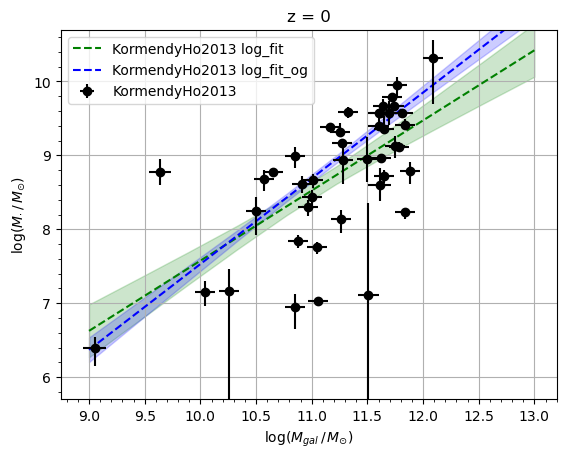

In [161]:
# Plot

name = 'kh13'

plt.clf()
plt.xlabel(r'$\log(M_{gal}\,/\,M_{\odot})$')
plt.ylabel(r'$\log(M_{\cdot}\,/\,M_{\odot})$')
plt.title('z = %s' % save_data['bhmsm'][name]['z'])

## Data
plt.errorbar(save_data['bhmsm'][name]['observables']['log_data']['x'], 
             save_data['bhmsm'][name]['observables']['log_data']['y'], 
             xerr=save_data['bhmsm'][name]['observables']['log_data']['xerr'], 
             yerr=save_data['bhmsm'][name]['observables']['log_data']['yerr'], 
             fmt='o', zorder=100, color='k', label=save_data['bhmsm'][name]['output_folder'])


## Binned means and medians
# plt.plot(save_data['bhmsm'][name]['observables']['binned_log_mean']['x'], 
#          save_data['bhmsm'][name]['observables']['binned_log_mean']['y'], 
#          ls='--', color='green', label='%s binned_log_mean' % (save_data['bhmsm'][name]['output_folder']))
# plt.fill_between(save_data['bhmsm'][name]['observables']['binned_log_mean']['x'], 
#                  save_data['bhmsm'][name]['observables']['binned_log_mean']['y'] - save_data['bhmsm'][name]['observables']['binned_log_mean']['yerr'], 
#                  save_data['bhmsm'][name]['observables']['binned_log_mean']['y'] + save_data['bhmsm'][name]['observables']['binned_log_mean']['yerr'],
#                  color='green', alpha=0.2)

# plt.plot(save_data['bhmsm'][name]['observables']['binned_log_median']['x'], 
#          save_data['bhmsm'][name]['observables']['binned_log_median']['y'], 
#          ls='--', color='blue', label='%s binned_log_median' % (save_data['bhmsm'][name]['output_folder']))
# plt.fill_between(save_data['bhmsm'][name]['observables']['binned_log_median']['x'], 
#                  save_data['bhmsm'][name]['observables']['binned_log_median']['y'] - save_data['bhmsm'][name]['observables']['binned_log_median']['yerr'][0], 
#                  save_data['bhmsm'][name]['observables']['binned_log_median']['y'] + save_data['bhmsm'][name]['observables']['binned_log_median']['yerr'][1],
#                  color='blue', alpha=0.2)


## Exact count binned means and medians
# plt.plot(save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['x'], 
#          save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['y'], 
#          ls='--', color='green', label='%s exact_count_binned_log_mean' % (save_data['bhmsm'][name]['output_folder']))
# plt.fill_between(save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['x'], 
#                  save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['y'] - save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['yerr'], 
#                  save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['y'] + save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['yerr'],
#                  color='green', alpha=0.2)

# plt.plot(save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['x'], 
#          save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['y'], 
#          ls='--', color='blue', label='%s exact_count_binned_log_median' % (save_data['bhmsm'][name]['output_folder']))
# plt.fill_between(save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['x'], 
#                  save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['y'] - save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['yerr'][0], 
#                  save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['y'] + save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['yerr'][1],
#                  color='blue', alpha=0.2)


## Min count binned means and medians
# plt.plot(save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['x'], 
#          save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['y'], 
#          ls='--', color='green', label='%s min_count_binned_log_mean' % (save_data['bhmsm'][name]['output_folder']))
# plt.fill_between(save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['x'], 
#                  save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['y'] - save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['yerr'], 
#                  save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['y'] + save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['yerr'],
#                  color='green', alpha=0.2)

# plt.plot(save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['x'], 
#          save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['y'], 
#          ls='--', color='blue', label='%s min_count_binned_log_median' % (save_data['bhmsm'][name]['output_folder']))
# plt.fill_between(save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['x'], 
#                  save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['y'] - save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['yerr'][0], 
#                  save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['y'] + save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['yerr'][1],
#                  color='blue', alpha=0.2)


## Fit
plt.plot(save_data['bhmsm'][name]['observables']['log_fit']['x'], 
         save_data['bhmsm'][name]['observables']['log_fit']['y'], 
         ls='--', color='green', label='%s log_fit' % (save_data['bhmsm'][name]['output_folder']))
plt.fill_between(save_data['bhmsm'][name]['observables']['log_fit']['x'], 
                 save_data['bhmsm'][name]['observables']['log_fit']['y'] - save_data['bhmsm'][name]['observables']['log_fit']['yerr'], 
                 save_data['bhmsm'][name]['observables']['log_fit']['y'] + save_data['bhmsm'][name]['observables']['log_fit']['yerr'],
                 color='green', alpha=0.2)

plt.plot(save_data['bhmsm'][name]['observables']['log_fit_og']['x'], 
         save_data['bhmsm'][name]['observables']['log_fit_og']['y'], 
         ls='--', color='blue', label='%s log_fit_og' % (save_data['bhmsm'][name]['output_folder']))
plt.fill_between(save_data['bhmsm'][name]['observables']['log_fit_og']['x'], 
                 save_data['bhmsm'][name]['observables']['log_fit_og']['y'] - save_data['bhmsm'][name]['observables']['log_fit_og']['yerr'][0], 
                 save_data['bhmsm'][name]['observables']['log_fit_og']['y'] + save_data['bhmsm'][name]['observables']['log_fit_og']['yerr'][1],
                 color='blue', alpha=0.2)





plt.ylim(np.log10(5e5), np.log10(5e10))
plt.legend()
plt.grid()
plt.minorticks_on()
plt.show()

## Bentz et al 2018 Black Hole mass - Stellar mass relation

In [162]:
# Bentz+2018
# Table 4

In [163]:
data_file = '/home/b/babul/aspadawe/data/observations/bhmsm/Bentz18/Bentz18_bhmsm.txt'
#data = np.genfromtxt(file, skip_header=1)
df = pd.read_csv(data_file, sep='\s+', index_col=False, skiprows=2)#, dtype=float)#, header=4)
# df = pd.read_csv(file, delimiter='\s+', index_col=False)
df

,Object,(V-H)gal(mag),"log(M*,bulge/Msun)(Bd01)","sigma_log(M*,bulge/Msun)(Bd01)","log(M*,bulge/Msun)(IP13)","sigma_log(M*,bulge/Msun)(IP13)",(V-H)gal(mag).1,"log(M*,gal/Msun)(Bd01)","sigma_log(M*,gal/Msun)(B01)","log(M*,gal/Msun)(IP13)","sigma_log(M*,gal/Msun)(IP13)",log(Mbh/Msun),sigma_lo_log(Mbh/Msun),sigma_hi_log(Mbh/Msun)
0,Mrk335,3.22,10.22,0.23,9.99,0.30,2.58,10.17,0.23,9.78,0.30,7.230,0.044,0.042
1,Mrk1501,2.82,10.82,0.23,10.49,0.30,1.64,10.63,0.23,10.00,0.30,8.067,0.165,0.119
2,PG0026+129,1.38,10.24,0.23,9.55,0.30,1.38,10.24,0.23,9.55,0.30,8.487,0.119,0.096
3,Mrk590,3.19,10.42,0.23,10.19,0.30,3.16,11.25,0.23,11.01,0.30,7.570,0.074,0.062
4,3C120,3.59,10.83,0.23,10.70,0.30,2.86,10.86,0.23,10.54,0.30,7.745,0.040,0.038
5,Akn120,2.87,10.85,0.23,10.53,0.30,2.66,11.04,0.23,10.68,0.30,8.068,0.063,0.048
6,Mrk6,3.67,10.93,0.23,10.82,0.30,2.62,10.68,0.23,10.31,0.30,8.102,0.041,0.037
7,Mrk79,3.25,10.49,0.23,10.27,0.30,2.59,10.69,0.23,10.31,0.30,7.612,0.136,0.107
8,PG0844+349,3.05,10.58,0.23,10.31,0.30,2.68,10.72,0.23,10.36,0.30,7.858,0.230,0.154
9,Mrk110,4.12,10.64,0.23,10.64,0.30,3.27,10.68,0.23,10.47,0.30,7.292,0.097,0.101


In [164]:
b18_log_Mbh = df['log(Mbh/Msun)'].to_numpy()
b18_log_Mbh_lo_err = df['sigma_lo_log(Mbh/Msun)'].to_numpy()
b18_log_Mbh_hi_err = df['sigma_hi_log(Mbh/Msun)'].to_numpy()

# IP13 more accurate/conservative than Bd01
b18_log_Mbulge = df['log(M*,bulge/Msun)(IP13)'].to_numpy()
b18_log_Mbulge_err = df['sigma_log(M*,bulge/Msun)(IP13)'].to_numpy()

b18_log_Mgal = df['log(M*,gal/Msun)(IP13)'].to_numpy()
b18_log_Mgal_err = df['sigma_log(M*,gal/Msun)(IP13)'].to_numpy()

In [165]:
min_log_Mstar = 9
max_log_Mstar = 13

In [166]:
save_data['bhmsm']['bentz18'] = {
    'observables':{},
    'output_directory':'/home/b/babul/aspadawe/data/observations/bhmsm',
    'output_folder':'Bentz18',
    'z':0,
    'z_lo':0,
    'z_hi':0,
    'citation':'Bentz et al (2018)',
    'bibcode':'2018ApJ...864..146B',
    'cosmology':FlatLambdaCDM(name=r'Flat $\Lambda$CDM', H0=68 * u.km / u.s / u.Mpc, Om0=0.3),
}

In [167]:
save_data['bhmsm']['bentz18']['observables']['log_data'] = {
    'x':b18_log_Mgal * unyt.Solar_Mass,
    'xerr':b18_log_Mgal_err * unyt.Solar_Mass,
    'y':b18_log_Mbh * unyt.Solar_Mass,
    'yerr':(b18_log_Mbh_lo_err, b18_log_Mbh_hi_err) * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'points',
    'name':'MBH-M*,gal Relation from Bentz+18',
    'comment':'Black Hole Mass - Stellar Mass relation from Bentz et al (2018)'
}

In [168]:
x_bin_centres, y_bin_means, y_bin_stds, y_bin_medians, y_bin_quantiles_lo, y_bin_quantiles_hi = gen.regular_bin(
    save_data['bhmsm']['bentz18']['observables']['log_data']['x'], 
    save_data['bhmsm']['bentz18']['observables']['log_data']['y'], 
    dx=0.5, min_x=min_log_Mstar, max_x=max_log_Mstar, calc_min_x=False, calc_max_x=False)

save_data['bhmsm']['bentz18']['observables']['binned_log_mean'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_means * unyt.Solar_Mass,
    'yerr':y_bin_stds * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M*,gal Relation from Bentz+18',
    'comment':'Black Hole Mass - Stellar Mass relation (means and standard deviations, binned regularly) from Bentz et al (2018)'
}

save_data['bhmsm']['bentz18']['observables']['binned_log_median'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_medians * unyt.Solar_Mass,
    'yerr':(np.abs(y_bin_medians - y_bin_quantiles_lo),
            np.abs(y_bin_medians - y_bin_quantiles_hi)) * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M*,gal Relation from Bentz+18',
    'comment':'Black Hole Mass - Stellar Mass relation (medians and 16/84 percentiles, binned regularly) from Bentz et al (2018)'
}

/gpfs/fs1/home/b/babul/aspadawe/scripts/gen_sim_data.py:373: RuntimeWarning: Mean of empty slice
  y_bin_means = np.array([np.nanmean(y_vals) for y_vals in y_binned])
/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1558: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [169]:
x_bin_centres, y_bin_means, y_bin_stds, y_bin_medians, y_bin_quantiles_lo, y_bin_quantiles_hi = gen.exact_count_bin(
    save_data['bhmsm']['bentz18']['observables']['log_data']['x'], 
    save_data['bhmsm']['bentz18']['observables']['log_data']['y'],
    Nbins=4, min_x=min_log_Mstar, max_x=max_log_Mstar)

save_data['bhmsm']['bentz18']['observables']['exact_count_binned_log_mean'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_means * unyt.Solar_Mass,
    'yerr':y_bin_stds * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M*,gal Relation from Bentz+18',
    'comment':'Black Hole Mass - Stellar Mass relation (means and standard deviations, exact count binned) from Bentz et al (2018)'
}

save_data['bhmsm']['bentz18']['observables']['exact_count_binned_log_median'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_medians * unyt.Solar_Mass,
    'yerr':(np.abs(y_bin_medians - y_bin_quantiles_lo),
            np.abs(y_bin_medians - y_bin_quantiles_hi)) * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M*,gal Relation from Bentz+18',
    'comment':'Black Hole Mass - Stellar Mass relation (medians and 16/84 percentiles, exact count binned) from Bentz et al (2018)'
}

In [170]:
x_bin_centres, y_bin_means, y_bin_stds, y_bin_medians, y_bin_quantiles_lo, y_bin_quantiles_hi = gen.min_count_bin(
    save_data['bhmsm']['bentz18']['observables']['log_data']['x'], 
    save_data['bhmsm']['bentz18']['observables']['log_data']['y'],
    x_lo=min_log_Mstar, x_hi=12, min_N_obj=3, min_bin_width=0.5, delta_x=0.02)

save_data['bhmsm']['bentz18']['observables']['min_count_binned_log_mean'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_means * unyt.Solar_Mass,
    'yerr':y_bin_stds * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M*,gal Relation from Bentz+18',
    'comment':'Black Hole Mass - Stellar Mass relation (means and standard deviations, min count binned) from Bentz et al (2018)'
}

save_data['bhmsm']['bentz18']['observables']['min_count_binned_log_median'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_medians * unyt.Solar_Mass,
    'yerr':(np.abs(y_bin_medians - y_bin_quantiles_lo),
            np.abs(y_bin_medians - y_bin_quantiles_hi)) * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M*,gal Relation from Bentz+18',
    'comment':'Black Hole Mass - Stellar Mass relation (medians and 16/84 percentiles, min count binned) from Bentz et al (2018)'
}

x_curr: 9  x_up: 9.52
bin width: 0.5199999999999996
N_obj: 0
Conditions not achieved

x_curr: 9  x_up: 9.54
bin width: 0.5399999999999991
N_obj: 1
Conditions not achieved

x_curr: 9  x_up: 9.559999999999999
bin width: 0.5599999999999987
N_obj: 2
Conditions not achieved

x_curr: 9  x_up: 9.579999999999998
bin width: 0.5799999999999983
N_obj: 3
Conditions achieved
Adding upper bin edge


x_curr: 9.579999999999998  x_up: 10.099999999999998
bin width: 0.5199999999999996
N_obj: 11
Conditions achieved
Adding upper bin edge


x_curr: 10.099999999999998  x_up: 10.619999999999997
bin width: 0.5199999999999996
N_obj: 11
Conditions achieved
Adding upper bin edge


x_curr: 10.619999999999997  x_up: 11.139999999999997
bin width: 0.5199999999999996
N_obj: 11
Conditions achieved
Adding upper bin edge


x_curr: 11.139999999999997  x_up: 11.659999999999997
bin width: 0.5199999999999996
N_obj: 1
Conditions not achieved

x_curr: 11.139999999999997  x_up: 11.679999999999996
bin width: 0.5399999999999991
N

In [171]:
log_x_arr = np.linspace(9, 13, 10)

# log_x_arr, log_y, log_y_err = gen.log_fit_fn_with_errors_for_fitting(
#     save_data['bhmsm']['kh13+b18']['observables']['binned_log_mean']['x'].value,
#     save_data['bhmsm']['kh13+b18']['observables']['log_data']['x'].value, 
#     save_data['bhmsm']['kh13+b18']['observables']['log_data']['y'].value, 
#     func=None, paper='kh13', determine_func=True)
# log_x_arr, log_y, log_y_err = gen.log_fit_fn_with_errors_for_fitting(
#     np.sort(save_data['bhmsm']['kh13+b18']['observables']['log_data']['x'].value),
#     save_data['bhmsm']['kh13+b18']['observables']['log_data']['x'].value, 
#     save_data['bhmsm']['kh13+b18']['observables']['log_data']['y'].value, 
#     func=None, paper='kh13', determine_func=True)
log_x_arr, log_y, log_y_err = gen.log_fit_fn_with_errors_for_fitting(
    log_x_arr,
    save_data['bhmsm']['bentz18']['observables']['log_data']['x'].value, 
    save_data['bhmsm']['bentz18']['observables']['log_data']['y'].value, 
    func=None, paper='b18', determine_func=True)


save_data['bhmsm']['bentz18']['observables']['log_fit'] = {
    'x':log_x_arr * unyt.Solar_Mass,
    'xerr':np.zeros(len(log_x_arr)) * unyt.Solar_Mass,
    'y':log_y * unyt.Solar_Mass,
    'yerr':log_y_err * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M*,gal Relation from Bentz+18',
    'comment':'Black Hole Mass - Stellar Mass relation (log-linear fit to data) from Bentz et al (2018)'
}

In [172]:
# Bentz+18, pg. 14 an 15, eqns 11, 12, 13, 14, 15, 16


# b18_fit_params = [0.49, 1.16]
# b18_fit_param_errs = [[-0.05, 0.06], [-0.08, 0.08]]  # [[lo, hi], [lo, hi]]

# # eqn 11: Mbulge, active galaxies, Bell & de Jong (2001) - Bd01
# b18_log_fit_params = [7.02, 1.06, 10]
# b18_log_fit_param_errs = [0.17, 0.24, 0]
# # eqn 12: Mbulge, active galaxies, Into & Portinari (2013) - IP13
# b18_log_fit_params = [7.36, 0.80, 10]
# b18_log_fit_param_errs = [0.15, 0.30, 0]
# # eqn 13: Mbulge, active+quiescent+megamaser galaxies, B01
# b18_log_fit_params = [7.16, 1.50, 10]
# b18_log_fit_param_errs = [0.11, 0.13, 0]

# # eqn 14: Mgal, active galaxies, Bell & de Jong (2001) - Bd01
# b18_log_fit_params = [8.05, 1.69, 11]
# b18_log_fit_param_errs = [0.18, 0.46, 0]
# # eqn 15: Mgal, active galaxies, Into & Portinari (2013) - IP13
# b18_log_fit_params = [8.49, 1.34, 11]
# b18_log_fit_param_errs = [0.41, 0.55, 0]
# eqn 16: Mgal, active+quiescent+megamaser galaxies, B01
b18_log_fit_params = [8.40, 1.84, 11]
b18_log_fit_param_errs = [0.09, 0.25, 0]


b18_log_fit_params = np.array(b18_log_fit_params)
b18_log_fit_param_errs = np.array(b18_log_fit_param_errs)


log_x_arr = np.linspace(9, 13, 10)

log_y, log_y_err = gen.log_fit_fn_with_errors(
    log_x_arr, b18_log_fit_params, b18_log_fit_param_errs,
    func=None, paper='b18', determine_func=True)


save_data['bhmsm']['bentz18']['observables']['log_fit_og'] = {
    'x':log_x_arr * unyt.Solar_Mass,
    'xerr':np.zeros(len(log_x_arr)) * unyt.Solar_Mass,
    'y':log_y * unyt.Solar_Mass,
    'yerr':log_y_err * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M*,gal Relation from Bentz+18',
    'comment':'Black Hole Mass - Stellar Mass relation (log-linear fit to data, with parameters from paper) from Bentz et al (2018)'
}

In [1]:
# Plot

name = 'bentz18'

plt.clf()
plt.xlabel(r'$\log(M_{gal}\,/\,M_{\odot})$')
plt.ylabel(r'$\log(M_{\cdot}\,/\,M_{\odot})$')
plt.title('z = %s' % save_data['bhmsm'][name]['z'])

## Data
plt.errorbar(save_data['bhmsm'][name]['observables']['log_data']['x'], 
             save_data['bhmsm'][name]['observables']['log_data']['y'], 
             xerr=save_data['bhmsm'][name]['observables']['log_data']['xerr'], 
             yerr=save_data['bhmsm'][name]['observables']['log_data']['yerr'], 
             fmt='o', zorder=100, color='k', label=save_data['bhmsm'][name]['output_folder'])


## Binned means and medians
# plt.plot(save_data['bhmsm'][name]['observables']['binned_log_mean']['x'], 
#          save_data['bhmsm'][name]['observables']['binned_log_mean']['y'], 
#          ls='--', color='green', label='%s binned_log_mean' % (save_data['bhmsm'][name]['output_folder']))
# plt.fill_between(save_data['bhmsm'][name]['observables']['binned_log_mean']['x'], 
#                  save_data['bhmsm'][name]['observables']['binned_log_mean']['y'] - save_data['bhmsm'][name]['observables']['binned_log_mean']['yerr'], 
#                  save_data['bhmsm'][name]['observables']['binned_log_mean']['y'] + save_data['bhmsm'][name]['observables']['binned_log_mean']['yerr'],
#                  color='green', alpha=0.2)

# plt.plot(save_data['bhmsm'][name]['observables']['binned_log_median']['x'], 
#          save_data['bhmsm'][name]['observables']['binned_log_median']['y'], 
#          ls='--', color='blue', label='%s binned_log_median' % (save_data['bhmsm'][name]['output_folder']))
# plt.fill_between(save_data['bhmsm'][name]['observables']['binned_log_median']['x'], 
#                  save_data['bhmsm'][name]['observables']['binned_log_median']['y'] - save_data['bhmsm'][name]['observables']['binned_log_median']['yerr'][0], 
#                  save_data['bhmsm'][name]['observables']['binned_log_median']['y'] + save_data['bhmsm'][name]['observables']['binned_log_median']['yerr'][1],
#                  color='blue', alpha=0.2)


## Exact count binned means and medians
# plt.plot(save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['x'], 
#          save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['y'], 
#          ls='--', color='green', label='%s exact_count_binned_log_mean' % (save_data['bhmsm'][name]['output_folder']))
# plt.fill_between(save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['x'], 
#                  save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['y'] - save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['yerr'], 
#                  save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['y'] + save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['yerr'],
#                  color='green', alpha=0.2)

# plt.plot(save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['x'], 
#          save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['y'], 
#          ls='--', color='blue', label='%s exact_count_binned_log_median' % (save_data['bhmsm'][name]['output_folder']))
# plt.fill_between(save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['x'], 
#                  save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['y'] - save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['yerr'][0], 
#                  save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['y'] + save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['yerr'][1],
#                  color='blue', alpha=0.2)


## Min count binned means and medians
plt.plot(save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['x'], 
         save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['y'], 
         ls='--', color='green', label='%s min_count_binned_log_mean' % (save_data['bhmsm'][name]['output_folder']))
plt.fill_between(save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['x'], 
                 save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['y'] - save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['yerr'], 
                 save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['y'] + save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['yerr'],
                 color='green', alpha=0.2)

plt.plot(save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['x'], 
         save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['y'], 
         ls='--', color='blue', label='%s min_count_binned_log_median' % (save_data['bhmsm'][name]['output_folder']))
plt.fill_between(save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['x'], 
                 save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['y'] - save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['yerr'][0], 
                 save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['y'] + save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['yerr'][1],
                 color='blue', alpha=0.2)


## Fit
# plt.plot(save_data['bhmsm'][name]['observables']['log_fit']['x'], 
#          save_data['bhmsm'][name]['observables']['log_fit']['y'], 
#          ls='--', color='green', label='%s log_fit' % (save_data['bhmsm'][name]['output_folder']))
# plt.fill_between(save_data['bhmsm'][name]['observables']['log_fit']['x'], 
#                  save_data['bhmsm'][name]['observables']['log_fit']['y'] - save_data['bhmsm'][name]['observables']['log_fit']['yerr'], 
#                  save_data['bhmsm'][name]['observables']['log_fit']['y'] + save_data['bhmsm'][name]['observables']['log_fit']['yerr'],
#                  color='green', alpha=0.2)

plt.plot(save_data['bhmsm'][name]['observables']['log_fit_og']['x'], 
         save_data['bhmsm'][name]['observables']['log_fit_og']['y'], 
         ls='--', color='blue', label='%s log_fit_og' % (save_data['bhmsm'][name]['output_folder']))
plt.fill_between(save_data['bhmsm'][name]['observables']['log_fit_og']['x'], 
                 save_data['bhmsm'][name]['observables']['log_fit_og']['y'] - save_data['bhmsm'][name]['observables']['log_fit_og']['yerr'][0], 
                 save_data['bhmsm'][name]['observables']['log_fit_og']['y'] + save_data['bhmsm'][name]['observables']['log_fit_og']['yerr'][1],
                 color='blue', alpha=0.2)





plt.ylim(np.log10(5e5), np.log10(5e10))
plt.legend()
plt.grid()
plt.minorticks_on()
plt.show()

NameError: name 'plt' is not defined

## Graham 2023 Black Hole mass - Stellar mass relation

In [174]:
# Graham 2023 (Splitting the lentils...) Black Hole Mass - Stellar Mass relation
# Table 1 (40 lenticular (S0) galaxies and ellicular (ES,b) galaxies)

In [175]:
data_file = '/home/b/babul/aspadawe/data/observations/bhmsm/Graham23/Graham23_bhmsm.txt'
#data = np.genfromtxt(file, skip_header=1)
df = pd.read_csv(data_file, sep='\s+', index_col=False, skiprows=2)#, dtype=float)#, header=4)
# df = pd.read_csv(file, delimiter='\s+', index_col=False)
df

,Galaxy,Type,log(Mbh/Msun),sigma_log(Mbh/Msun),"log(M∗,sph/Msun)","sigma_log(M∗,sph/Msun)","log(M∗,gal/Msun)","sigma_log(M∗,gal/Msun)"
0,NGC0404†,S0,5.74,0.10,8.03,0.50,9.19,0.16
1,NGC1332,"ES,b",9.15,0.07,11.15,0.15,11.17,0.14
2,NGC1374,S0,8.76,0.05,10.30,0.16,10.59,0.13
3,NGC2549,S0,7.15,0.60,9.67,0.19,10.21,0.17
4,NGC2778,S0,7.18,0.35,9.49,0.23,10.15,0.17
5,NGC2787†,S0,7.59,0.09,9.37,0.24,10.10,0.19
6,NGC3115,"ES,b",8.94,0.25,10.87,0.14,10.95,0.13
7,NGC3245,S0,8.30,0.12,10.12,0.17,10.70,0.15
8,NGC3998,S0,8.33,0.43,10.12,0.26,10.61,0.15
9,NGC4026,S0,8.26,0.12,10.19,0.22,10.44,0.17


In [176]:
g23_log_Mbh = df['log(Mbh/Msun)'].to_numpy()
g23_log_Mbh_err = df['sigma_log(Mbh/Msun)'].to_numpy()

g23_log_Msph = df['log(M∗,sph/Msun)'].to_numpy()
g23_log_Msph_err = df['sigma_log(M∗,sph/Msun)'].to_numpy()

g23_log_Mgal = df['log(M∗,gal/Msun)'].to_numpy()
g23_log_Mgal_err = df['sigma_log(M∗,gal/Msun)'].to_numpy()

In [177]:
min_log_Mstar = 9
max_log_Mstar = 13

In [178]:
save_data['bhmsm']['graham23'] = {
    'observables':{},
    'output_directory':'/home/b/babul/aspadawe/data/observations/bhmsm',
    'output_folder':'Graham23',
    'z':0,
    'z_lo':0,
    'z_hi':0,
    'citation':'Graham (2023)',
    'bibcode':'2023MNRAS.521.1023G',
    'cosmology':FlatLambdaCDM(name=r'Flat $\Lambda$CDM', H0=68 * u.km / u.s / u.Mpc, Om0=0.3),
}

In [179]:
save_data['bhmsm']['graham23']['observables']['log_data'] = {
    'x':g23_log_Mgal * unyt.Solar_Mass,
    'xerr':g23_log_Mgal_err * unyt.Solar_Mass,
    'y':g23_log_Mbh * unyt.Solar_Mass,
    'yerr':g23_log_Mbh_err * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'points',
    'name':'MBH-M*,gal Relation from Graham (2023)',
    'comment':'Black Hole Mass - Galaxy Stellar Mass relation from Graham (2023) for 40 lenticular (S0) and ellicular (ES,b) galaxies'
}

In [180]:
x_bin_centres, y_bin_means, y_bin_stds, y_bin_medians, y_bin_quantiles_lo, y_bin_quantiles_hi = gen.regular_bin(
    save_data['bhmsm']['graham23']['observables']['log_data']['x'], 
    save_data['bhmsm']['graham23']['observables']['log_data']['y'], 
    dx=0.5, min_x=min_log_Mstar, max_x=max_log_Mstar, calc_min_x=False, calc_max_x=False)

save_data['bhmsm']['graham23']['observables']['binned_log_mean'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_means * unyt.Solar_Mass,
    'yerr':y_bin_stds * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M*,gal Relation from Graham (2023)',
    'comment':'Black Hole Mass - Galaxy Stellar Mass relation (means and standard deviations, binned regularly) from Graham (2023) for 40 lenticular (S0) and ellicular (ES,b) galaxies'
}

save_data['bhmsm']['graham23']['observables']['binned_log_median'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_medians * unyt.Solar_Mass,
    'yerr':(np.abs(y_bin_medians - y_bin_quantiles_lo),
            np.abs(y_bin_medians - y_bin_quantiles_hi)) * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M*,gal Relation from Graham (2023)',
    'comment':'Black Hole Mass - Galaxy Stellar Mass relation (medians and 16/84 percentiles, binned regularly) from Graham (2023) for 40 lenticular (S0) and ellicular (ES,b) galaxies'
}

/gpfs/fs1/home/b/babul/aspadawe/scripts/gen_sim_data.py:373: RuntimeWarning: Mean of empty slice
  y_bin_means = np.array([np.nanmean(y_vals) for y_vals in y_binned])
/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1558: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [181]:
x_bin_centres, y_bin_means, y_bin_stds, y_bin_medians, y_bin_quantiles_lo, y_bin_quantiles_hi = gen.exact_count_bin(
    save_data['bhmsm']['graham23']['observables']['log_data']['x'], 
    save_data['bhmsm']['graham23']['observables']['log_data']['y'],
    Nbins=3, min_x=10, max_x=max_log_Mstar)

save_data['bhmsm']['graham23']['observables']['exact_count_binned_log_mean'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_means * unyt.Solar_Mass,
    'yerr':y_bin_stds * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M*,gal Relation from Graham (2023)',
    'comment':'Black Hole Mass - Galaxy Stellar Mass relation (means and standard deviations, exact count binned) from Graham (2023) for 40 lenticular (S0) and ellicular (ES,b) galaxies'
}

save_data['bhmsm']['graham23']['observables']['exact_count_binned_log_median'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_medians * unyt.Solar_Mass,
    'yerr':(np.abs(y_bin_medians - y_bin_quantiles_lo),
            np.abs(y_bin_medians - y_bin_quantiles_hi)) * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M*,gal Relation from Graham (2023)',
    'comment':'Black Hole Mass - Galaxy Stellar Mass relation (medians and 16/84 percentiles, exact count binned) from Graham (2023) for 40 lenticular (S0) and ellicular (ES,b) galaxies'
}

In [182]:
x_bin_centres, y_bin_means, y_bin_stds, y_bin_medians, y_bin_quantiles_lo, y_bin_quantiles_hi = gen.min_count_bin(
    save_data['bhmsm']['graham23']['observables']['log_data']['x'], 
    save_data['bhmsm']['graham23']['observables']['log_data']['y'],
    x_lo=min_log_Mstar, x_hi=max_log_Mstar, min_N_obj=3, min_bin_width=1, delta_x=0.02)

save_data['bhmsm']['graham23']['observables']['min_count_binned_log_mean'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_means * unyt.Solar_Mass,
    'yerr':y_bin_stds * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M*,gal Relation from Graham (2023)',
    'comment':'Black Hole Mass - Galaxy Stellar Mass relation (means and standard deviations, min count binned) from Graham (2023) for 40 lenticular (S0) and ellicular (ES,b) galaxies'
}

save_data['bhmsm']['graham23']['observables']['min_count_binned_log_median'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_medians * unyt.Solar_Mass,
    'yerr':(np.abs(y_bin_medians - y_bin_quantiles_lo),
            np.abs(y_bin_medians - y_bin_quantiles_hi)) * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M*,gal Relation from Graham (2023)',
    'comment':'Black Hole Mass - Galaxy Stellar Mass relation (medians and 16/84 percentiles, min count binned) from Graham (2023) for 40 lenticular (S0) and ellicular (ES,b) galaxies'
}

x_curr: 9  x_up: 10.02
bin width: 1.0199999999999996
N_obj: 1
Conditions not achieved

x_curr: 9  x_up: 10.04
bin width: 1.0399999999999991
N_obj: 1
Conditions not achieved

x_curr: 9  x_up: 10.059999999999999
bin width: 1.0599999999999987
N_obj: 1
Conditions not achieved

x_curr: 9  x_up: 10.079999999999998
bin width: 1.0799999999999983
N_obj: 2
Conditions not achieved

x_curr: 9  x_up: 10.099999999999998
bin width: 1.0999999999999979
N_obj: 2
Conditions not achieved

x_curr: 9  x_up: 10.119999999999997
bin width: 1.1199999999999974
N_obj: 3
Conditions achieved
Adding upper bin edge


x_curr: 10.119999999999997  x_up: 11.139999999999997
bin width: 1.0199999999999996
N_obj: 27
Conditions achieved
Adding upper bin edge


x_curr: 11.139999999999997  x_up: 12.159999999999997
bin width: 1.0199999999999996
N_obj: 10
Conditions achieved
Adding upper bin edge


x_curr: 12.159999999999997  x_up: 13.179999999999996
bin width: 1.0199999999999996
N_obj: 0
x_up hit x_hi
Conditions not achieved

x_

/gpfs/fs1/home/b/babul/aspadawe/scripts/gen_sim_data.py:481: RuntimeWarning: Mean of empty slice
  y_bin_means = np.array([np.nanmean(y_vals) for y_vals in y_binned])
/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1558: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [183]:
log_x_arr = np.linspace(9, 13, 10)

# log_x_arr, log_y, log_y_err = gen.log_fit_fn_with_errors_for_fitting(
#     save_data['bhmsm']['kh13+b18']['observables']['binned_log_mean']['x'].value,
#     save_data['bhmsm']['kh13+b18']['observables']['log_data']['x'].value, 
#     save_data['bhmsm']['kh13+b18']['observables']['log_data']['y'].value, 
#     func=None, paper='kh13', determine_func=True)
# log_x_arr, log_y, log_y_err = gen.log_fit_fn_with_errors_for_fitting(
#     np.sort(save_data['bhmsm']['kh13+b18']['observables']['log_data']['x'].value),
#     save_data['bhmsm']['kh13+b18']['observables']['log_data']['x'].value, 
#     save_data['bhmsm']['kh13+b18']['observables']['log_data']['y'].value, 
#     func=None, paper='kh13', determine_func=True)
log_x_arr, log_y, log_y_err = gen.log_fit_fn_with_errors_for_fitting(
    log_x_arr,
    save_data['bhmsm']['graham23']['observables']['log_data']['x'].value, 
    save_data['bhmsm']['graham23']['observables']['log_data']['y'].value, 
    func=None, paper='g23', determine_func=True)


save_data['bhmsm']['graham23']['observables']['log_fit'] = {
    'x':log_x_arr * unyt.Solar_Mass,
    'xerr':np.zeros(len(log_x_arr)) * unyt.Solar_Mass,
    'y':log_y * unyt.Solar_Mass,
    'yerr':log_y_err * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M*,gal Relation from Graham (2023)',
    'comment':'Black Hole Mass - Galaxy Stellar Mass relation (log-linear fit to data) from Graham (2023) for 40 lenticular (S0) and ellicular (ES,b) galaxies'
}

In [184]:
# Graham23, pg. 9, eqns 2, 3, and Fig 4 caption
# pg. 10 eqn 4 and Fig 6 caption



# g23_fit_params = [0.49, 1.16]
# g23_fit_param_errs = [[-0.05, 0.06], [-0.08, 0.08]]  # [[lo, hi], [lo, hi]]

# # Fig. 4: 32 unlabelled S0 galaxies (M*,sph) - left, cyan line
# g23_log_fit_params = [8.04, 1.63, 10.33]
# g23_log_fit_param_errs = [0.15, 0.18, 0]
# # Fig. 4: 25 unlabelled S galaxies (M*,sph) - left, grey line
# g23_log_fit_params = [7.18, 2.27, 10.09]
# g23_log_fit_param_errs = [0.15, 0.48, 0]
# # Fig. 4: 13 dust-poor S0 galaxies (M*,sph) - right, red line
# g23_log_fit_params = [7.43, 2.39, 9.90]
# g23_log_fit_param_errs = [0.18, 0.81, 0]
# # Fig. 4: 17 dust-poor S0 galaxies (M*,sph) - right, dashed orange line
# g23_log_fit_params = [7.57, 2.70, 9.96]
# g23_log_fit_param_errs = [0.18, 0.77, 0]
# # Fig. 4: 15 dusty S0 galaxies (M*,sph) - right, blue line
# g23_log_fit_params = [8.42, 3.69, 10.70]
# g23_log_fit_param_errs = [0.15, 1.51, 0]
# # Fig. 4: 15 dusty S0 galaxies (M*,sph) - right, blue line
# g23_log_fit_params = [8.42, 3.69, 10.70]
# g23_log_fit_param_errs = [0.15, 1.51, 0]

# Fig. 6: 32 unlabelled S0 galaxies (M*,gal) - left, cyan line
g23_log_fit_params = [8.05, 1.97, 10.75]
g23_log_fit_param_errs = [0.15, 0.29, 0]
# # Fig. 6: 25 unlabelled S galaxies (M*,gal) - left, grey line
# g23_log_fit_params = [7.18, 2.72, 10.79]
# g23_log_fit_param_errs = [0.14, 0.49, 0]
# # Fig. 6: 15 dusty S0 galaxies (M*,gal) - right, dashed blue line
# g23_log_fit_params = [8.28, 2.59, 11.09]
# g23_log_fit_param_errs = [0.18, 0.54, 0]



g23_log_fit_params = np.array(g23_log_fit_params)
g23_log_fit_param_errs = np.array(g23_log_fit_param_errs)



log_x_arr = np.linspace(9, 13, 10)

log_y, log_y_err = gen.log_fit_fn_with_errors(
    log_x_arr, g23_log_fit_params, g23_log_fit_param_errs,
    func=None, paper='g23', determine_func=True)


save_data['bhmsm']['graham23']['observables']['log_fit_og'] = {
    'x':log_x_arr * unyt.Solar_Mass,
    'xerr':np.zeros(len(log_x_arr)) * unyt.Solar_Mass,
    'y':log_y * unyt.Solar_Mass,
    'yerr':log_y_err * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M*,gal Relation from Graham (2023)',
    'comment':'Black Hole Mass - Galaxy Stellar Mass relation (log-linear fit to data, with parameters from paper) from Graham (2023) for 40 lenticular (S0) and ellicular (ES,b) galaxies'
}

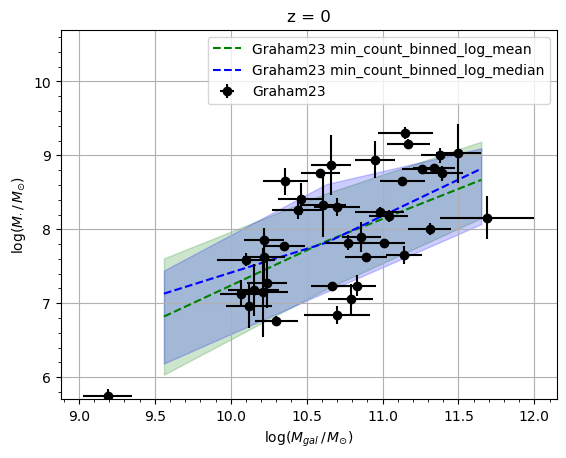

In [185]:
# Plot

name = 'graham23'

plt.clf()
plt.xlabel(r'$\log(M_{gal}\,/\,M_{\odot})$')
plt.ylabel(r'$\log(M_{\cdot}\,/\,M_{\odot})$')
plt.title('z = %s' % save_data['bhmsm'][name]['z'])

## Data
plt.errorbar(save_data['bhmsm'][name]['observables']['log_data']['x'], 
             save_data['bhmsm'][name]['observables']['log_data']['y'], 
             xerr=save_data['bhmsm'][name]['observables']['log_data']['xerr'], 
             yerr=save_data['bhmsm'][name]['observables']['log_data']['yerr'], 
             fmt='o', zorder=100, color='k', label=save_data['bhmsm'][name]['output_folder'])


## Binned means and medians
# plt.plot(save_data['bhmsm'][name]['observables']['binned_log_mean']['x'], 
#          save_data['bhmsm'][name]['observables']['binned_log_mean']['y'], 
#          ls='--', color='green', label='%s binned_log_mean' % (save_data['bhmsm'][name]['output_folder']))
# plt.fill_between(save_data['bhmsm'][name]['observables']['binned_log_mean']['x'], 
#                  save_data['bhmsm'][name]['observables']['binned_log_mean']['y'] - save_data['bhmsm'][name]['observables']['binned_log_mean']['yerr'], 
#                  save_data['bhmsm'][name]['observables']['binned_log_mean']['y'] + save_data['bhmsm'][name]['observables']['binned_log_mean']['yerr'],
#                  color='green', alpha=0.2)

# plt.plot(save_data['bhmsm'][name]['observables']['binned_log_median']['x'], 
#          save_data['bhmsm'][name]['observables']['binned_log_median']['y'], 
#          ls='--', color='blue', label='%s binned_log_median' % (save_data['bhmsm'][name]['output_folder']))
# plt.fill_between(save_data['bhmsm'][name]['observables']['binned_log_median']['x'], 
#                  save_data['bhmsm'][name]['observables']['binned_log_median']['y'] - save_data['bhmsm'][name]['observables']['binned_log_median']['yerr'][0], 
#                  save_data['bhmsm'][name]['observables']['binned_log_median']['y'] + save_data['bhmsm'][name]['observables']['binned_log_median']['yerr'][1],
#                  color='blue', alpha=0.2)


## Exact count binned means and medians
# plt.plot(save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['x'], 
#          save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['y'], 
#          ls='--', color='green', label='%s exact_count_binned_log_mean' % (save_data['bhmsm'][name]['output_folder']))
# plt.fill_between(save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['x'], 
#                  save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['y'] - save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['yerr'], 
#                  save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['y'] + save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['yerr'],
#                  color='green', alpha=0.2)

# plt.plot(save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['x'], 
#          save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['y'], 
#          ls='--', color='blue', label='%s exact_count_binned_log_median' % (save_data['bhmsm'][name]['output_folder']))
# plt.fill_between(save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['x'], 
#                  save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['y'] - save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['yerr'][0], 
#                  save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['y'] + save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['yerr'][1],
#                  color='blue', alpha=0.2)


## Min count binned means and medians
plt.plot(save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['x'], 
         save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['y'], 
         ls='--', color='green', label='%s min_count_binned_log_mean' % (save_data['bhmsm'][name]['output_folder']))
plt.fill_between(save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['x'], 
                 save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['y'] - save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['yerr'], 
                 save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['y'] + save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['yerr'],
                 color='green', alpha=0.2)

plt.plot(save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['x'], 
         save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['y'], 
         ls='--', color='blue', label='%s min_count_binned_log_median' % (save_data['bhmsm'][name]['output_folder']))
plt.fill_between(save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['x'], 
                 save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['y'] - save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['yerr'][0], 
                 save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['y'] + save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['yerr'][1],
                 color='blue', alpha=0.2)


## Fit
# plt.plot(save_data['bhmsm'][name]['observables']['log_fit']['x'], 
#          save_data['bhmsm'][name]['observables']['log_fit']['y'], 
#          ls='--', color='green', label='%s log_fit' % (save_data['bhmsm'][name]['output_folder']))
# plt.fill_between(save_data['bhmsm'][name]['observables']['log_fit']['x'], 
#                  save_data['bhmsm'][name]['observables']['log_fit']['y'] - save_data['bhmsm'][name]['observables']['log_fit']['yerr'], 
#                  save_data['bhmsm'][name]['observables']['log_fit']['y'] + save_data['bhmsm'][name]['observables']['log_fit']['yerr'],
#                  color='green', alpha=0.2)

# plt.plot(save_data['bhmsm'][name]['observables']['log_fit_og']['x'], 
#          save_data['bhmsm'][name]['observables']['log_fit_og']['y'], 
#          ls='--', color='blue', label='%s log_fit_og' % (save_data['bhmsm'][name]['output_folder']))
# plt.fill_between(save_data['bhmsm'][name]['observables']['log_fit_og']['x'], 
#                  save_data['bhmsm'][name]['observables']['log_fit_og']['y'] - save_data['bhmsm'][name]['observables']['log_fit_og']['yerr'][0], 
#                  save_data['bhmsm'][name]['observables']['log_fit_og']['y'] + save_data['bhmsm'][name]['observables']['log_fit_og']['yerr'][1],
#                  color='blue', alpha=0.2)





plt.ylim(np.log10(5e5), np.log10(5e10))
plt.legend()
plt.grid()
plt.minorticks_on()
plt.show()

## Combining KH13 and Bentz+18 datasets into joint data

In [186]:
min_log_Mstar = 9
max_log_Mstar = 13

In [196]:
save_data['bhmsm']['kh13+bentz18'] = {
    'observables':{},
    'output_directory':'/home/b/babul/aspadawe/data/observations/bhmsm',
    'output_folder':'KH13+Bentz18',
    'z':0,
    'z_lo':0,
    'z_hi':0,
    'citation':'Kormendy & Ho (2013); Bentz et al (2018)',
    'bibcode':'2013ARA&A..51..511; 2018ApJ...864..146B',
    'cosmology':FlatLambdaCDM(name=r'Flat $\Lambda$CDM', H0=68 * u.km / u.s / u.Mpc, Om0=0.3),
}

In [197]:
save_data['bhmsm']['kh13+bentz18']['observables']['log_data'] = {
    'x':np.append(save_data['bhmsm']['kh13']['observables']['log_data']['x'].value, save_data['bhmsm']['bentz18']['observables']['log_data']['x'].value) * save_data['bhmsm']['kh13']['observables']['log_data']['x'].units,
    'xerr':np.append(save_data['bhmsm']['kh13']['observables']['log_data']['xerr'].value, save_data['bhmsm']['bentz18']['observables']['log_data']['xerr'].value, axis=-1) * save_data['bhmsm']['kh13']['observables']['log_data']['xerr'].units,
    'y':np.append(save_data['bhmsm']['kh13']['observables']['log_data']['y'].value, save_data['bhmsm']['bentz18']['observables']['log_data']['y'].value) * save_data['bhmsm']['kh13']['observables']['log_data']['x'].units,
    'yerr':np.append(save_data['bhmsm']['kh13']['observables']['log_data']['yerr'].value, save_data['bhmsm']['bentz18']['observables']['log_data']['yerr'].value, axis=-1) * save_data['bhmsm']['kh13']['observables']['log_data']['yerr'].units,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'points',
    'name':'MBH-M* Relation from KH13 (M*=Mbulge) and Bentz+18 (M*=M*,gal)',
    'comment':'Black Hole Mass - Stellar Mass relation from Kormendy and Ho (2013) for classical bulges and elliptical galaxies, and Bentz et al (2018) for galaxy stellar mass'
}

In [198]:
x_bin_centres, y_bin_means, y_bin_stds, y_bin_medians, y_bin_quantiles_lo, y_bin_quantiles_hi = gen.regular_bin(
    save_data['bhmsm']['kh13+bentz18']['observables']['log_data']['x'], 
    save_data['bhmsm']['kh13+bentz18']['observables']['log_data']['y'], 
    dx=1, min_x=min_log_Mstar, max_x=max_log_Mstar, calc_min_x=False, calc_max_x=False)

save_data['bhmsm']['kh13+bentz18']['observables']['binned_log_mean'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_means * unyt.Solar_Mass,
    'yerr':y_bin_stds * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M* Relation from KH13 (M*=Mbulge) and Bentz+18 (M*=M*,gal)',
    'comment':'Black Hole Mass - Stellar Mass relation (means and standard deviations, binned regularly) from Kormendy and Ho (2013) for classical bulges and elliptical galaxies, and Bentz et al (2018) for galaxy stellar mass'
}

save_data['bhmsm']['kh13+bentz18']['observables']['binned_log_median'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_medians * unyt.Solar_Mass,
    'yerr':(np.abs(y_bin_medians - y_bin_quantiles_lo),
            np.abs(y_bin_medians - y_bin_quantiles_hi)) * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M* Relation from KH13 (M*=Mbulge) and Bentz+18 (M*=M*,gal)',
    'comment':'Black Hole Mass - Stellar Mass relation (medians and 16/84 percentiles, binned regularly) from Kormendy and Ho (2013) for classical bulges and elliptical galaxies, and Bentz et al (2018) for galaxy stellar mass'
}

In [199]:
x_bin_centres, y_bin_means, y_bin_stds, y_bin_medians, y_bin_quantiles_lo, y_bin_quantiles_hi = gen.exact_count_bin(
    save_data['bhmsm']['kh13+bentz18']['observables']['log_data']['x'], 
    save_data['bhmsm']['kh13+bentz18']['observables']['log_data']['y'],
    Nbins=5, min_x=min_log_Mstar, max_x=max_log_Mstar)

save_data['bhmsm']['kh13+bentz18']['observables']['exact_count_binned_log_mean'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_means * unyt.Solar_Mass,
    'yerr':y_bin_stds * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M* Relation from KH13 (M*=Mbulge) and Bentz+18 (M*=M*,gal)',
    'comment':'Black Hole Mass - Stellar Mass relation (means and standard deviations, exact count binned) from Kormendy and Ho (2013) for classical bulges and elliptical galaxies, and Bentz et al (2018) for galaxy stellar mass'
}

save_data['bhmsm']['kh13+bentz18']['observables']['exact_count_binned_log_median'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_medians * unyt.Solar_Mass,
    'yerr':(np.abs(y_bin_medians - y_bin_quantiles_lo),
            np.abs(y_bin_medians - y_bin_quantiles_hi)) * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M* Relation from KH13 (M*=Mbulge) and Bentz+18 (M*=M*,gal)',
    'comment':'Black Hole Mass - Stellar Mass relation (medians and 16/84 percentiles, exact count binned) from Kormendy and Ho (2013) for classical bulges and elliptical galaxies, and Bentz et al (2018) for galaxy stellar mass'
}

In [200]:
x_bin_centres, y_bin_means, y_bin_stds, y_bin_medians, y_bin_quantiles_lo, y_bin_quantiles_hi = gen.min_count_bin(
    save_data['bhmsm']['kh13+bentz18']['observables']['log_data']['x'], 
    save_data['bhmsm']['kh13+bentz18']['observables']['log_data']['y'],
    x_lo=min_log_Mstar, x_hi=max_log_Mstar, min_N_obj=3, min_bin_width=0.5, delta_x=0.02)

save_data['bhmsm']['kh13+bentz18']['observables']['min_count_binned_log_mean'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_means * unyt.Solar_Mass,
    'yerr':y_bin_stds * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M* Relation from KH13 (M*=Mbulge) and Bentz+18 (M*=M*,gal)',
    'comment':'Black Hole Mass - Stellar Mass relation (means and standard deviations, min count binned) from Kormendy and Ho (2013) for classical bulges and elliptical galaxies, and Bentz et al (2018) for galaxy stellar mass'
}

save_data['bhmsm']['kh13+bentz18']['observables']['min_count_binned_log_median'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_medians * unyt.Solar_Mass,
    'yerr':(np.abs(y_bin_medians - y_bin_quantiles_lo),
            np.abs(y_bin_medians - y_bin_quantiles_hi)) * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M* Relation from KH13 (M*=Mbulge) and Bentz+18 (M*=M*,gal)',
    'comment':'Black Hole Mass - Stellar Mass relation (medians and 16/84 percentiles, min count binned) from Kormendy and Ho (2013) for classical bulges and elliptical galaxies, and Bentz et al (2018) for galaxy stellar mass'
}

x_curr: 9  x_up: 9.52
bin width: 0.5199999999999996
N_obj: 1
Conditions not achieved

x_curr: 9  x_up: 9.54
bin width: 0.5399999999999991
N_obj: 2
Conditions not achieved

x_curr: 9  x_up: 9.559999999999999
bin width: 0.5599999999999987
N_obj: 3
Conditions achieved
Adding upper bin edge


x_curr: 9.559999999999999  x_up: 10.079999999999998
bin width: 0.5199999999999996
N_obj: 13
Conditions achieved
Adding upper bin edge


x_curr: 10.079999999999998  x_up: 10.599999999999998
bin width: 0.5199999999999996
N_obj: 15
Conditions achieved
Adding upper bin edge


x_curr: 10.599999999999998  x_up: 11.119999999999997
bin width: 0.5199999999999996
N_obj: 21
Conditions achieved
Adding upper bin edge


x_curr: 11.119999999999997  x_up: 11.639999999999997
bin width: 0.5199999999999996
N_obj: 14
Conditions achieved
Adding upper bin edge


x_curr: 11.639999999999997  x_up: 12.159999999999997
bin width: 0.5199999999999996
N_obj: 14
Conditions achieved
Adding upper bin edge


x_curr: 12.159999999999997

/gpfs/fs1/home/b/babul/aspadawe/scripts/gen_sim_data.py:481: RuntimeWarning: Mean of empty slice
  y_bin_means = np.array([np.nanmean(y_vals) for y_vals in y_binned])
/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1558: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [201]:
log_x_arr = np.linspace(9, 13, 10)

# log_x_arr, log_y, log_y_err = gen.log_fit_fn_with_errors_for_fitting(
#     save_data['bhmsm']['kh13+b18']['observables']['binned_log_mean']['x'].value,
#     save_data['bhmsm']['kh13+b18']['observables']['log_data']['x'].value, 
#     save_data['bhmsm']['kh13+b18']['observables']['log_data']['y'].value, 
#     func=None, paper='kh13', determine_func=True)
# log_x_arr, log_y, log_y_err = gen.log_fit_fn_with_errors_for_fitting(
#     np.sort(save_data['bhmsm']['kh13+b18']['observables']['log_data']['x'].value),
#     save_data['bhmsm']['kh13+b18']['observables']['log_data']['x'].value, 
#     save_data['bhmsm']['kh13+b18']['observables']['log_data']['y'].value, 
#     func=None, paper='kh13', determine_func=True)
log_x_arr, log_y, log_y_err = gen.log_fit_fn_with_errors_for_fitting(
    log_x_arr,
    save_data['bhmsm']['kh13+bentz18']['observables']['log_data']['x'].value, 
    save_data['bhmsm']['kh13+bentz18']['observables']['log_data']['y'].value, 
    func=None, paper='kh13', determine_func=True)


save_data['bhmsm']['kh13+bentz18']['observables']['log_fit'] = {
    'x':log_x_arr * unyt.Solar_Mass,
    'xerr':np.zeros(len(log_x_arr)) * unyt.Solar_Mass,
    'y':log_y * unyt.Solar_Mass,
    'yerr':log_y_err * unyt.Solar_Mass,
    'x_label':'log(Mstar)',
    'y_label':'log(Mbh)',
    'plot_as':'line',
    'name':'MBH-M* Relation from KH13 (M*=Mbulge) and Bentz+18 (M*=M*,gal)',
    'comment':'Black Hole Mass - Stellar Mass relation (log-linear fit to data) from Kormendy and Ho (2013) for classical bulges and elliptical galaxies, and Bentz et al (2018) for galaxy stellar mass'
}

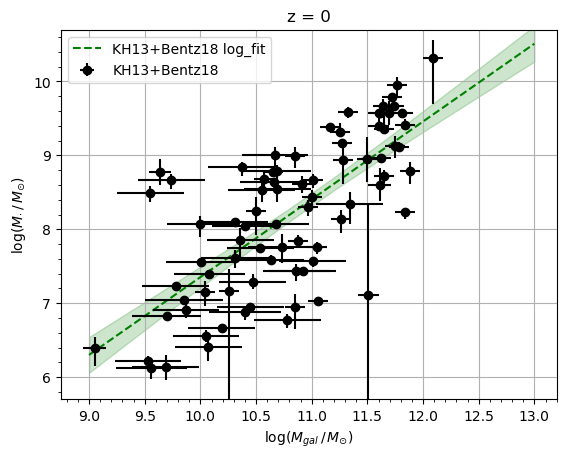

In [202]:
# Plot

name = 'kh13+bentz18'

plt.clf()
plt.xlabel(r'$\log(M_{gal}\,/\,M_{\odot})$')
plt.ylabel(r'$\log(M_{\cdot}\,/\,M_{\odot})$')
plt.title('z = %s' % save_data['bhmsm'][name]['z'])

## Data
plt.errorbar(save_data['bhmsm'][name]['observables']['log_data']['x'], 
             save_data['bhmsm'][name]['observables']['log_data']['y'], 
             xerr=save_data['bhmsm'][name]['observables']['log_data']['xerr'], 
             yerr=save_data['bhmsm'][name]['observables']['log_data']['yerr'], 
             fmt='o', zorder=100, color='k', label=save_data['bhmsm'][name]['output_folder'])


## Binned means and medians
# plt.plot(save_data['bhmsm'][name]['observables']['binned_log_mean']['x'], 
#          save_data['bhmsm'][name]['observables']['binned_log_mean']['y'], 
#          ls='--', color='green', label='%s binned_log_mean' % (save_data['bhmsm'][name]['output_folder']))
# plt.fill_between(save_data['bhmsm'][name]['observables']['binned_log_mean']['x'], 
#                  save_data['bhmsm'][name]['observables']['binned_log_mean']['y'] - save_data['bhmsm'][name]['observables']['binned_log_mean']['yerr'], 
#                  save_data['bhmsm'][name]['observables']['binned_log_mean']['y'] + save_data['bhmsm'][name]['observables']['binned_log_mean']['yerr'],
#                  color='green', alpha=0.2)

# plt.plot(save_data['bhmsm'][name]['observables']['binned_log_median']['x'], 
#          save_data['bhmsm'][name]['observables']['binned_log_median']['y'], 
#          ls='--', color='blue', label='%s binned_log_median' % (save_data['bhmsm'][name]['output_folder']))
# plt.fill_between(save_data['bhmsm'][name]['observables']['binned_log_median']['x'], 
#                  save_data['bhmsm'][name]['observables']['binned_log_median']['y'] - save_data['bhmsm'][name]['observables']['binned_log_median']['yerr'][0], 
#                  save_data['bhmsm'][name]['observables']['binned_log_median']['y'] + save_data['bhmsm'][name]['observables']['binned_log_median']['yerr'][1],
#                  color='blue', alpha=0.2)


## Exact count binned means and medians
# plt.plot(save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['x'], 
#          save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['y'], 
#          ls='--', color='green', label='%s exact_count_binned_log_mean' % (save_data['bhmsm'][name]['output_folder']))
# plt.fill_between(save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['x'], 
#                  save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['y'] - save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['yerr'], 
#                  save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['y'] + save_data['bhmsm'][name]['observables']['exact_count_binned_log_mean']['yerr'],
#                  color='green', alpha=0.2)

# plt.plot(save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['x'], 
#          save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['y'], 
#          ls='--', color='blue', label='%s exact_count_binned_log_median' % (save_data['bhmsm'][name]['output_folder']))
# plt.fill_between(save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['x'], 
#                  save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['y'] - save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['yerr'][0], 
#                  save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['y'] + save_data['bhmsm'][name]['observables']['exact_count_binned_log_median']['yerr'][1],
#                  color='blue', alpha=0.2)


## Min count binned means and medians
# plt.plot(save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['x'], 
#          save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['y'], 
#          ls='--', color='green', label='%s min_count_binned_log_mean' % (save_data['bhmsm'][name]['output_folder']))
# plt.fill_between(save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['x'], 
#                  save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['y'] - save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['yerr'], 
#                  save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['y'] + save_data['bhmsm'][name]['observables']['min_count_binned_log_mean']['yerr'],
#                  color='green', alpha=0.2)

# plt.plot(save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['x'], 
#          save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['y'], 
#          ls='--', color='blue', label='%s min_count_binned_log_median' % (save_data['bhmsm'][name]['output_folder']))
# plt.fill_between(save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['x'], 
#                  save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['y'] - save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['yerr'][0], 
#                  save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['y'] + save_data['bhmsm'][name]['observables']['min_count_binned_log_median']['yerr'][1],
#                  color='blue', alpha=0.2)


## Fit
plt.plot(save_data['bhmsm'][name]['observables']['log_fit']['x'], 
         save_data['bhmsm'][name]['observables']['log_fit']['y'], 
         ls='--', color='green', label='%s log_fit' % (save_data['bhmsm'][name]['output_folder']))
plt.fill_between(save_data['bhmsm'][name]['observables']['log_fit']['x'], 
                 save_data['bhmsm'][name]['observables']['log_fit']['y'] - save_data['bhmsm'][name]['observables']['log_fit']['yerr'], 
                 save_data['bhmsm'][name]['observables']['log_fit']['y'] + save_data['bhmsm'][name]['observables']['log_fit']['yerr'],
                 color='green', alpha=0.2)





plt.ylim(np.log10(5e5), np.log10(5e10))
plt.legend()
plt.grid()
plt.minorticks_on()
plt.show()

## Madau & Dickinson (2014) Cosmic Star Formation History (CSFH)

In [4]:
save_data['csfh']['md14'] = {
    'observables':{},
    'output_directory':'/home/b/babul/aspadawe/data/observations/csfh',
    'output_folder':'MD14',
    'z':0,
    'z_lo':0,
    'z_hi':0,
    'citation':'Madau & Dickinson (2014)',
    'bibcode':'',
    'cosmology':FlatLambdaCDM(name=r'Flat $\Lambda$CDM', H0=68 * u.km / u.s / u.Mpc, Om0=0.3),
}

In [5]:
unyt.dimensionless

dimensionless

In [18]:
xx = 10 * unyt.msun / (unyt.year * unyt.Mpc ** 3)
print(xx)
logxx = np.log10(xx)
print(logxx)

10 Msun/(Mpc**3*yr)


AttributeError: module 'unyt' has no attribute 'log'

In [10]:
# MD14 CSFH (cosmic SFRD)

# data_md14 = np.genfromtxt('/home/b/babul/rennehan/analysis/gizmo-noir-analysis/Observation_Romeel/md14_data.txt')
# data_md14 = np.genfromtxt('/scratch/b/babul/renierht/Python_scripts/Observation_Romeel/md14_data.txt')
# data_md14 = np.genfromtxt('/home/b/babul/aspadawe/scripts/rennehan/Observation_Romeel/md14_data.txt')
data_md14 = np.genfromtxt('/home/b/babul/aspadawe/data/observations/csfh/MD14/md14_data.txt')

z_md14 = data_md14[:,0]
log_sfrd_md14 = data_md14[:,1]
log_sfrd_err_hi_md14 = data_md14[:,2]
log_sfrd_err_lo_md14 = np.abs(data_md14[:,3])

## Calculate linear values and errors
sfrd_md14 = 10**log_sfrd_md14

# Require point that errorbars reach to be the same value in linear and log space
# ie. y+(-)Dy = x+(-)Dx --> Dy = x+(-)Dx -(+) Dy   (Dx = Delta(x) = error on x)
sfrd_err_hi_md14 = np.abs(sfrd_md14 - 10**(log_sfrd_md14 + log_sfrd_err_hi_md14))
sfrd_err_lo_md14 = np.abs(sfrd_md14 - 10**(log_sfrd_md14 - log_sfrd_err_lo_md14))

# Calculate errorbars with error propogation
# ie. Dy/Dx ~ dy/dx --> Dy = Dx * dy/dx
sfrd_err_hi_md14_v2 = np.abs(np.log(10) * 10**log_sfrd_md14 * log_sfrd_err_hi_md14)
sfrd_err_lo_md14_v2 = np.abs(np.log(10) * 10**log_sfrd_md14 * log_sfrd_err_lo_md14)

# Require relative errorbars in linear and log space to be the same
# ie. Dy/y = Dx/x --> Dy = y * Dx/x
sfrd_err_hi_md14_v3 = np.abs(sfrd_md14 * log_sfrd_err_hi_md14/log_sfrd_md14)
sfrd_err_lo_md14_v3 = np.abs(sfrd_md14 * log_sfrd_err_lo_md14/log_sfrd_md14)


save_data['csfh']['md14']['observables']['log_data'] = {
    'x':np.log10(1+z_md14) * unyt.dimensionless,
    'xerr':np.zeros(len(np.log10(1+z_md14))) * unyt.dimensionless,
    'y':log_sfrd_md14 * unyt.msun / (unyt.year * unyt.Mpc**3),
    'yerr':(log_sfrd_err_lo_md14, log_sfrd_err_hi_md14) * unyt.msun / (unyt.year * unyt.Mpc**3),
    'x_label':'z',
    'y_label':'Psi=SFRD',
    'plot_as':'points',
    'name':'CSFH from Madau & Dickinson (2014)',
    'comment':'Cosmic Star Formation History from Madau & Dickinson (2014) from UV and IR data'
}

In [57]:
# Madau and Dickinson 2014
def sfr_theoretical(one_plus_z, sim_h):
    norm = 0.015
    numerator = one_plus_z**2.7
    denominator = 1.0 + (one_plus_z / 2.9)**5.6
    h = 0.7

    # Renormalize to arbitrary little-h
    # 1.7 is from Salpeter to Chabrier
    fac = (1.0 / 1.65) * sim_h / h

    return np.log10(norm * numerator * fac / denominator)

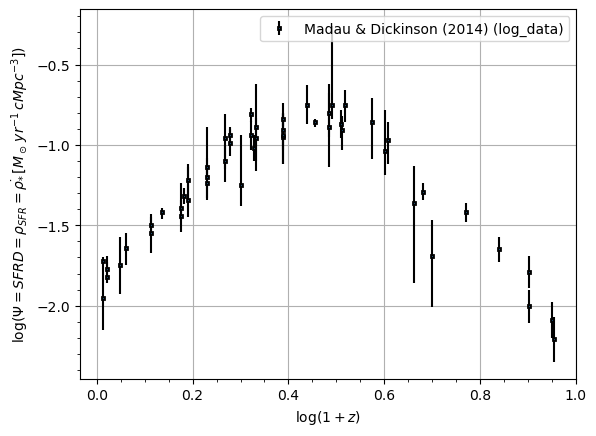

In [13]:
#fig, ax = plt.subplots()
plt.clf()
# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(0, 3)
#plt.ylim(-2.2, -0.5)
# plt.xlim(0, 8)
# plt.ylim(-2.5, -0.5)

plt.xlabel(r'$\log(1+z)$')
plt.ylabel(r'$\log(\Psi=SFRD=\rho_{SFR}=\dot{\rho_{*}}\, [M_\odot\, yr^{-1}\, cMpc^{-3}])$')
# plt.title(r'%s' % (cali_num))
plt.grid()
plt.minorticks_on()
plt.errorbar(save_data['csfh']['md14']['observables']['log_data']['x'], 
             save_data['csfh']['md14']['observables']['log_data']['y'], 
             yerr=save_data['csfh']['md14']['observables']['log_data']['yerr'], 
             label='%s (%s)' % (save_data['csfh']['md14']['citation'], 'log_data'), 
             marker='s', ms=2, mec='black', mew=2, ecolor='black', ls='')
plt.legend()
plt.show()

# Save all data to hdf5 files with velociraptor

In [14]:
# Save data

for observable, paper in save_data.items():
    print(observable)
    print()
    for paper_, info in paper.items():
        print(paper_)
        print()
        for obs_type, obs_info in info['observables'].items():    
            print(obs_type)
            
            if not os.path.exists(info['output_directory']):
                os.mkdir(info['output_directory'])

            output_path = os.path.join(info['output_directory'], info['output_folder'])
            if not os.path.exists(output_path):
                os.mkdir(output_path)


            processed = ObservationalData()
            processed.associate_x(obs_info['x'], scatter=obs_info['xerr'], comoving=True, description=obs_info['x_label'])
            processed.associate_y(obs_info['y'], scatter=obs_info['yerr'], comoving=True, description=obs_info['y_label'])
            processed.associate_citation(info['citation'], info['bibcode'])
            processed.associate_name(obs_info['name'])
            processed.associate_comment(obs_info['comment'])
            processed.associate_redshift(info['z'], info['z_lo'], info['z_hi'])
            processed.associate_plot_as(obs_info['plot_as'])
            processed.associate_cosmology(info['cosmology'])

            output_filename = "%s_%s_%s.hdf5" % (paper_, observable, obs_type)
            full_output_path = os.path.join(output_path, output_filename)

            if os.path.exists(full_output_path):
                os.remove(full_output_path)

            processed.write(filename=full_output_path)
            
            print('success')
            print()
            
        print()
        print()
        
    print()
    print()
    print()

gsmf




ssfr




bhmsm




csfh

md14

log_data
success






